In [319]:
'''
subtyping by projection patterns
'''

'\nsubtyping by projection patterns\n'

In [320]:
import numpy as np
import pandas as pd
import scipy
import re
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import time
import os

import neuro_morpho_toolbox as nmt
from neuro_morpho_toolbox.flat_map import *

import sklearn
from sklearn.decomposition import PCA
import umap
from sklearn import metrics
import hdbscan

import pickle
%matplotlib inline

In [321]:
[ns] = pickle.load(open('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/ipython/neuron_set_1741cells.pickle', 'rb'))

## Load metadata

In [322]:
metadata = ns.metadata.copy()
metadata['Cluster'] = 'unknown'
metadata.rename(columns={'Manually_corrected_soma_region':'CellType',
                         'Cortical_layer':'Layer'
                        }, inplace=True)
metadata['CellType'] = metadata['CellType'].str.strip()
metadata['CreLine'] = ''
idx = metadata[~metadata['Transgenic_line'].isna()].index.tolist()
metadata.loc[idx, 'CreLine'] = [i.split('-')[0] for i in metadata.loc[idx, 'Transgenic_line'].tolist()]

metadata.head()

,formatted name,Soma_x,Soma_y,Soma_z,Registered_soma_region,CellType,Layer,Transgenic_line,Brain_id,Subclass_or_type,Notes,Cluster,CreLine
17109_1701_x8048_y22277,17109_1701_x8048_y22277,2723.000,3720.100,3799.050,AId,AId,6,Gnb4-IRES2-CreERT2;Ai140_297974-17109,17109,Car3,NaN,unknown,Gnb4
17109_1801_x6698_y12550,17109_1801_x6698_y12550,2840.900,3417.850,3868.175,AId,AId,6,Gnb4-IRES2-CreERT2;Ai140_297974-17109,17109,Car3,NaN,unknown,Gnb4
17109_1901_x9602_y10508,17109_1901_x9602_y10508,3075.100,4599.350,3051.700,AId,AId,6,Gnb4-IRES2-CreERT2;Ai140_297974-17109,17109,Car3,NaN,unknown,Gnb4
17109_2201_x8046_y23301,17109_2201_x8046_y23301,3230.875,3565.525,3383.525,MOs,MOs,6,Gnb4-IRES2-CreERT2;Ai140_297974-17109,17109,Car3,NaN,unknown,Gnb4
17109_2301_x8535_y23051,17109_2301_x8535_y23051,3332.700,3778.725,3448.950,AId,AId,6,Gnb4-IRES2-CreERT2;Ai140_297974-17109,17109,Car3,NaN,unknown,Gnb4


## B) L5 PT cells from Fezf2 and Pvalb mice

In [5]:
metadata = metadata[metadata['Subclass_or_type']=='CTX_ET'].copy()
print(metadata['CreLine'].value_counts())

# Combine SSp types
idlist = [i for i in metadata.index.tolist() if metadata.loc[i, 'CellType'].startswith('SSp')]
metadata.loc[idlist, 'CellType'] = 'SSp'

# Combine VIS types
idlist = [i for i in metadata.index.tolist() if metadata.loc[i, 'CellType'].startswith('VIS')]
metadata.loc[idlist, 'CellType'] = 'VIS'


# Full celltype: region + layer
metadata['CellType_full']=[';'.join([metadata.loc[i, 'CellType'], 
                               'L'+str(metadata.loc[i, 'Layer'])
                              ]) for i in metadata.index.tolist()]

metadata.CellType.value_counts().sort_index()

Pvalb    186
Fezf2     52
Name: CreLine, dtype: int64


ACAv        1
ADUv        1
AId         3
AIv         1
ENTl        1
GU          2
MOp        19
MOs        16
ORBl        1
ORBm        1
ORBvl       3
RSPagl      1
RSPd        2
RSPv       18
SSp       141
SSs        21
VIS         6
Name: CellType, dtype: int64

# cells: 6


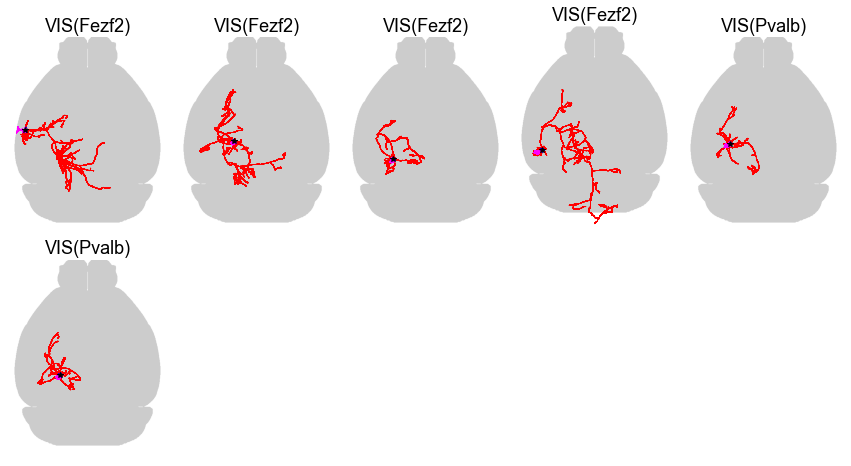

In [6]:
## Display 'interneurons':
## Show neurons with long-projecting arbors
name_list = metadata[[i.startswith('VIS') for i in metadata['CellType'].tolist()]].index.tolist()


ncol = 5
nrow = int(len(name_list)/ncol) + int((len(name_list)%ncol)>0)
fig, ax = plt.subplots(nrow, ncol, figsize=(3*ncol, 4*nrow), gridspec_kw={'wspace':0.05, 'hspace':0.05})
ax = ax.reshape(-1,)

print("# cells: %d" % (len(name_list)))
for i, cur_cell in enumerate(name_list[:]):    
    nmt.cell_in_map(ns.neurons, 
                [cur_cell], metadata, 
                ccf_annotation=nmt.annotation, 
                view="Horizontal", 
                alpha=1,
                ax=ax[i]
               )
    ax[i].set_title(('%s(%s)' % (metadata.loc[cur_cell, 'CellType'], 
                                 metadata.loc[cur_cell, 'CreLine'])), fontdict={'fontsize':18})
    ax[i].axis('off')

for i in range(len(name_list), ncol*nrow):
    ax[i].axis('off')

In [7]:
selected_celltype = ['MOp;L5', 'MOs;L5', 'SSp;L5', 'SSs;L5']
selected_region = ['MOp', 'MOs', 'SSp', 'SSs']

test_list = metadata[((metadata['CellType'].isin(selected_region)))].index.tolist()
# test_list = metadata[((metadata['CellType_full'].isin(selected_celltype)))].index.tolist()
metadata = metadata.loc[test_list].copy()

print('# candidate cells:\t%d' % (len(metadata)))

# candidate cells:	197


In [8]:
# metadata.to_excel('../Data/Hongkui/metadata_PT_new.xlsx')

In [9]:
selected_celltype = ['MOp;L5', 'MOs;L5', 'SSp;L5', 'SSs;L5']
selected_region = ['MOp', 'MOs', 'SSp', 'SSs']

# test_list = metadata[((metadata['CellType'].isin(selected_region)))].index.tolist()
test_list = metadata[((metadata['CellType_full'].isin(selected_celltype)))].index.tolist()
metadata = metadata.loc[test_list].copy()

print('# candidate cells:\t%d' % (len(metadata)))
metadata['CellType_full'].value_counts()

# candidate cells:	196


SSp;L5    140
SSs;L5     21
MOp;L5     19
MOs;L5     16
Name: CellType_full, dtype: int64

In [10]:
metadata['CreLine'].value_counts()

Pvalb    161
Fezf2     35
Name: CreLine, dtype: int64

## Sholl analysis to define the best threshold for long arbors

In [11]:
# def my_get_segments(cn):
#     child = cn.swc[cn.swc.parent != (-1)]
#     parent = cn.swc.loc[child.parent]
#     soma = np.array(cn.soma[['x', 'y', 'z']])

#     # Distance to soma
#     cr = np.sqrt(np.sum(np.square(child[['x', 'y', 'z']] - soma), axis=1))
#     pr = np.sqrt(np.sum(np.square(parent[['x', 'y', 'z']] - soma), axis=1))
#     res = pd.DataFrame({"cx":child.x.tolist(),
#                         "cy":child.y.tolist(),
#                         "cz":child.z.tolist(),
#                         "cr":cr.tolist(),
#                         "c_name":child.index.tolist(),
#                         "px":parent.x.tolist(),
#                         "py":parent.y.tolist(),
#                         "pz":parent.z.tolist(),
#                         "pr":pr.tolist(),
#                         "p_name":parent.index.tolist(),
#                         })
#     return res
    
# def get_crossing(cur_neuron, step, r_max, custom_soma=None):
#     df = my_get_segments(cur_neuron)
#     df['is_cross'] = False
#     df['at_cross'] = -1
#     r_list = []
#     ct_list = []
#     cur_r = 0
#     while cur_r < r_max:
#         lab = ((df.pr <= cur_r) & (df.cr > cur_r)) | ((df.pr > cur_r) & (df.cr <= cur_r))
#         df.loc[lab, 'is_cross'] = True
#         df.loc[lab, 'at_cross'] = cur_r
#         r_list.append(cur_r)
#         ct_list.append(int(sum(lab)))
#         cur_r = cur_r + step
#     ct_df = pd.DataFrame({'r': r_list, 'count': ct_list})
#     return cur_neuron, df, ct_df




In [12]:
# sholl = None
# for cname in test_list[:]:   
#     _, _, tp = get_crossing(ns.neurons[cname], 50, 5000)
#     tp.rename(columns={'count':cname}, inplace=True)
#     if sholl is None:
#         sholl = tp
#     else:
#         sholl[cname] = tp[cname]
    

In [13]:
# plt.plot(sholl['r'], sholl.iloc[:,1:].median(axis=1))


### Separate out interneurons

In [14]:
def dist2soma(swc, soma):
    return sklearn.metrics.pairwise_distances(swc[['x', 'y', 'z']], soma[['x', 'y', 'z']])


In [15]:
def long_axon_arbor(cn, node_type_list=[2], radius=1000):
    csoma = cn.soma.copy()
    cseg = cn.get_segments()
    cseg['soma_distance'] = dist2soma(cseg, csoma).reshape(-1,)
    cseg = cseg[((cseg.soma_distance>radius) & (cseg.type.isin(node_type_list)))].copy()
    if len(cseg)==0:
        return 0
    return cseg['rho'].sum()


In [16]:
radius = 1000
print('# candidate cells:\t%d' % (len(metadata)))
metadata['Long_arbor(mm)'] = [long_axon_arbor(ns.neurons[i], radius=radius)/1000 for i in metadata.index.tolist()]

# candidate cells:	196


# cells: 3


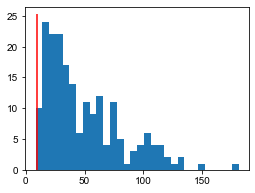

In [17]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
_ = ax.hist(metadata['Long_arbor(mm)'], bins=30)

thres = 10
ax.vlines(x=thres, ymin=0, ymax=ax.get_ylim()[1], color='r')

print("# cells: %d" % ((metadata['Long_arbor(mm)']<thres).sum()))


# cells: 3


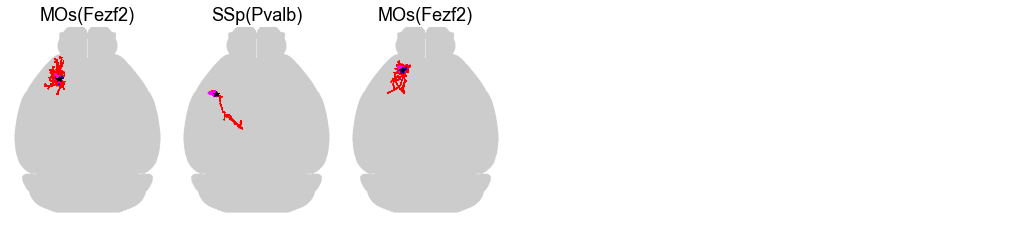

In [18]:
## Display 'interneurons':
## Show neurons with long-projecting arbors
name_list = metadata[metadata['Long_arbor(mm)']<thres].sort_values(['Long_arbor(mm)']).index.tolist()[:]

ncol = 6
nrow = int(len(name_list)/ncol) + int((len(name_list)%ncol)>0)
fig, ax = plt.subplots(nrow, ncol, figsize=(3*ncol, 4*nrow), gridspec_kw={'wspace':0.05, 'hspace':0.05})
ax = ax.reshape(-1,)

print("# cells: %d" % (len(name_list)))
for i, cur_cell in enumerate(name_list[:]):    
    nmt.cell_in_map(ns.neurons, 
                [cur_cell], metadata, 
                ccf_annotation=nmt.annotation, 
                view="Horizontal", 
                alpha=1,
                ax=ax[i]
               )
    ax[i].set_title(('%s(%s)' % (metadata.loc[cur_cell, 'CellType'], 
                                 metadata.loc[cur_cell, 'CreLine'])), fontdict={'fontsize':18})
    ax[i].axis('off')

for i in range(len(name_list), ncol*nrow):
    ax[i].axis('off')


In [19]:
# interneuron_list = ['18047_3132_x24052_y12385',
#                     '18047_2622_x11862_y12983']
interneuron_list = name_list
metadata = metadata[~metadata.index.isin(interneuron_list)] 
metadata['CellType_full'].value_counts()

SSp;L5    139
SSs;L5     21
MOp;L5     19
MOs;L5     14
Name: CellType_full, dtype: int64

In [20]:
metadata.to_excel('./metadata_PT_v2.xlsx')

In [293]:
ct_palette = ['C'+str(i) for i in range(8)]
ct_cmap = {}
for i,ct in enumerate(selected_celltype):
    ct_cmap[ct]=ct_palette[i]

region_palette = ['C'+str(i) for i in range(8)]
region_cmap = {}
for i,ct in enumerate(['SSs', 'MOs', 'SSp', 'MOp']):
    region_cmap[ct]=region_palette[i]
    
    
cre_palette = ['C'+str(i) for i in range(8)]
cre_cmap = {}
for i,cre in enumerate(metadata.CreLine.unique().tolist()):
    cre_cmap[cre]=cre_palette[i]

palette = sns.palettes.color_palette('tab10')
cmap = dict(zip(selected_celltype,palette[:len(selected_celltype)]))


(0.0, 0.01, -0.15000000000000002, 3.15)

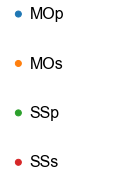

In [22]:
fig, ax = plt.subplots(1,1,figsize=(2,3))
colors = [region_cmap[i] for i in selected_region]
colors.reverse()

ax.scatter([0.001]*len(region_cmap), np.arange(len(region_cmap)), c=colors)
for i, key in enumerate(selected_region):
    ax.text(0.002, len(region_cmap)-i-1, key, 
            horizontalalignment='left',
            verticalalignment="center",
            fontdict={"size":16}
           )
ax.set_xlim(0, 0.01)
ax.axis("off")
# fig.savefig('../Figure/color_code_celltype.pdf', bbox_inches='tight')

In [23]:
test_list = metadata.index.tolist()
print('# Total\t%d' % (len(test_list)))
metadata['CellType_full'].value_counts()

# Total	193


SSp;L5    139
SSs;L5     21
MOp;L5     19
MOs;L5     14
Name: CellType_full, dtype: int64

In [24]:
# name_list = metadata.sort_values(['CellType_full', 'Long_arbor(mm)']).index.tolist()

# ncol = 8
# nrow = int(len(name_list)/ncol) + int((len(name_list)%ncol)>0)
# fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow), gridspec_kw={'wspace':0.05, 'hspace':0.05})
# ax = ax.reshape(-1,)

# print("# cells: %d" % (len(name_list)))
# for i, cur_cell in enumerate(name_list[:]):    
#     nmt.cell_in_map(ns.neurons, 
#                 [cur_cell], metadata, 
#                 ccf_annotation=nmt.annotation, 
#                 view="Sagittal", 
#                 alpha=1,
#                 ax=ax[i]
#                )
#     ax[i].set_title(('%s(%s)' % (metadata.loc[cur_cell, 'CellType_full'], 
#                                  metadata.loc[cur_cell, 'CreLine'])), fontdict={'fontsize':14})
#     ax[i].axis('off')

# for i in range(len(name_list), ncol*nrow):
#     ax[i].axis('off')
    
# fig.savefig('../Figure/Single_neuron_L5_PT.pdf', bbox_inches='tight')

## Separate neuron as source and target

In [25]:
def extract(d, keys):
    return dict((k, d[k]) for k in keys if k in d)

In [26]:
[ns_target] = pickle.load(open('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/ipython/neuron_set_1741cells.pickle', 'rb'))
[ns_source] = pickle.load(open('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/ipython/neuron_set_1741cells.pickle', 'rb'))


In [27]:
ns_target.neurons = extract(ns_target.neurons, test_list)
ns_source.neurons = extract(ns_source.neurons, test_list)


In [28]:
node_type_list = [2]

radius = 1000

for cname in test_list:
    cn = ns.neurons[cname]
    # Find segemnts that are close to soma
    csoma = cn.soma.copy()
    cswc = cn.swc.copy()
    cswc['soma_distance'] = dist2soma(cswc, csoma).reshape(-1,)
    ns_target.neurons[cname].swc = cswc[((cswc.soma_distance>radius) & (cswc.type.isin(node_type_list)))].copy()
    ns_source.neurons[cname].swc = cswc[((cswc.soma_distance<radius) & (cswc.type.isin(node_type_list)))].copy()
    

In [29]:
def recalculate_projection(ns):
    ns.features['projection_features'] = nmt.neuron_features.projection_features()
    ns.features['projection_features'].load_data_from_neuron_dict(ns.neurons)
    return

recalculate_projection(ns_target)
recalculate_projection(ns_source)

Number of input neurons: 193
Number of input features: 632
Number of input neurons: 193
Number of input features: 632


## Classification

In [30]:
MY_regions = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('MY') if i in nmt.bs.selected_regions] + ['MY-mot', 'MY-sen', 'MY-sat', 'MY_mot', 'MY_sen', 'MY_sat']
MY_regions = sorted(MY_regions)

CTX_regions = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('CTX') if i in nmt.bs.selected_regions]+['SSp']
CTX_regions = sorted(CTX_regions)

TH_regions = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('TH') if i in nmt.bs.selected_regions]
TH_regions = sorted(TH_regions)

MB_regions = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('MB') if i in nmt.bs.selected_regions]
MB_regions = sorted(MB_regions)

HB_regions = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('HB') if i in nmt.bs.selected_regions]
HB_regions = sorted(HB_regions)


HY_regions = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('HY') if i in nmt.bs.selected_regions]
HY_regions = sorted(HY_regions)

CNU_regions = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('CNU') if i in nmt.bs.selected_regions]
CNU_regions = sorted(CNU_regions)


In [31]:

def group_regions(in_regions):
    tp_dict = {'MY':[i.replace('-', '_') for i in MY_regions],
               'MB':[i.replace('-', '_') for i in MB_regions],
               'HB':[i.replace('-', '_') for i in HB_regions],
               'TH':[i.replace('-', '_') for i in TH_regions],
               'HY':[i.replace('-', '_') for i in HY_regions],
               'CNU':[i.replace('-', '_') for i in CNU_regions],
               'CTX':[i.replace('-', '_') for i in CTX_regions]
              }
    res = []
    for cr in in_regions:
        added = False
        tr = cr.replace('-', '_').replace('ipsi_', '').replace('contra_', '').replace('local_', '')
        for i in list(tp_dict.keys()):
            if tr in tp_dict[i]:
                res.append(i)
                added = True
                break
        if not added:
            res.append('others')
    res = pd.DataFrame({'Group':pd.Categorical(res, categories=group_list)}, 
                       index=in_regions)
    res = res.sort_values(['Group'])
    return res
        

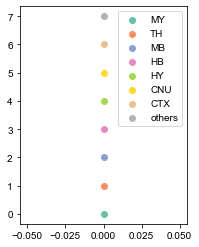

In [32]:
group_list = ['MY', 'TH', 'MB', 'HB', 'HY', 'CNU', 'CTX']

group_palette = sns.palettes.color_palette('Set2')
group_cmap = dict(zip(group_list+['others'],
                      group_palette[:len(group_list)+1]))
xs = [0]*len(group_cmap)
ys = np.arange(len(group_cmap))
fig,ax = plt.subplots(1,1, figsize=(3,4))
for i in range(len(xs)):
    cr = list(group_cmap.keys())[i]
    ax.scatter(xs[i], ys[i], c=[group_cmap[cr]], label=cr)
_ = ax.legend()
fig.savefig('../Figure/PT_region_color_code.pdf', bbox_inches='tight')

In [304]:
cluster_palette = sns.palettes.color_palette('tab20')


cluster_palette[2] = 'red'
cluster_palette[3] = 'orange'
cluster_palette[6] = 'magenta'
cluster_palette[7] = 'purple'


In [34]:
def my_ssp_combine(tdf):
    tdf['ipsi_SSp-f'] = tdf[['ipsi_SSp-bfd', 'ipsi_SSp-m', 'ipsi_SSp-n']].sum(axis=1) # combine as SSp-face
    tdf['ipsi_SSp-tl'] = tdf[['ipsi_SSp-tr', 'ipsi_SSp-ul', 'ipsi_SSp-ll']].sum(axis=1) # combine as SSp-trunck/limb


    tdf['contra_SSp-f'] = tdf[['contra_SSp-bfd', 'contra_SSp-m', 'contra_SSp-n']].sum(axis=1) # combine as SSp-face
    tdf['contra_SSp-tl'] = tdf[['contra_SSp-tr', 'contra_SSp-ul', 'contra_SSp-ll']].sum(axis=1) # combine as SSp-trunck/limb


    tdf.drop(columns=['ipsi_SSp-bfd', 'ipsi_SSp-m', 'ipsi_SSp-n', 'ipsi_SSp-tr', 'ipsi_SSp-ul', 'ipsi_SSp-ll',
                      'contra_SSp-bfd', 'contra_SSp-m', 'contra_SSp-n', 'contra_SSp-tr', 'contra_SSp-ul', 'contra_SSp-ll',
                      'ipsi_SSp-un', 'contra_SSp-un'
                     ], inplace=True)
    return tdf

def sum_regions(x, region='SSp'):
    for tag in ['ipsi_', 'contra_']:
        tp_list = [tag+nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id(region)]
        tp_list = [i for i in tp_list if i in (x.columns.tolist())]
        res = x[tp_list].sum(axis=1)
        x.drop(columns=tp_list, inplace=True)
        x[tag+region] = res
#         print(len(tp_list))
    return x

def get_clean_pdf(namelist, 
                  ns,
                  thres=1, 
                  min_cell_count=3, 
                  min_region_count=1,
                  combine_ssp=False,
                  combine_my=False,
                 ):
    
    tdf = ns.features['projection_features'].raw_data.loc[namelist].copy()/1000
    tdf.drop(columns=['ipsi_fiber tracts', 'contra_fiber tracts'], inplace=True)
    if combine_ssp:
        tdf = sum_regions(tdf, region='SSp')
#         tdf = my_ssp_combine(tdf)
    if combine_my:
        for i in ['MY-mot', 'MY-sen', 'MY-sat']:
            tdf = sum_regions(tdf, i)
    flist = tdf.columns[(tdf>thres).sum(axis=0)>=min_cell_count].tolist()
    print("# regions:\t%d" % (len(flist)))
    tdf = tdf[flist]
    clist = tdf.index[(tdf>thres).sum(axis=1)>=min_region_count].tolist()
    print("# total cells:\t%d" % (len(namelist)))
    print("# selected cells:\t%d" % (len(clist)))
    return tdf.loc[clist, flist]

def get_combined_pdf(namelist,
                     thres=1,
                     min_cell_count=3, 
                     min_region_count=1,
                     combine_ssp=True,
                     combine_my=True,
                     drop_ctx=False,
                    ):
    # Source matrix
    sdf = get_clean_pdf(namelist, 
                        ns_source, 
                        thres=thres, 
                        min_cell_count=min_cell_count,
                        min_region_count=-1,
                        combine_ssp=combine_ssp,
                        combine_my=combine_my,
                       )
    contra_list = [i for i in sdf.columns.tolist() if i.startswith('contra')]
    sdf.drop(columns=contra_list, inplace=True)
    rename_list = [i.replace('ipsi_', 'local_') for i in sdf.columns.tolist()]
    rename_dict = dict(zip(sdf.columns.tolist(), rename_list))
    sdf.rename(columns=rename_dict, inplace=True)
    
    # Target matrix
    tdf = get_clean_pdf(namelist, 
                        ns_target, 
                        thres=thres, 
                        min_cell_count=min_cell_count,
                        min_region_count=-1,
                        combine_ssp=combine_ssp,
                        combine_my=combine_my
                       )    
    
    # Combine
    tdf = tdf[tdf.index.isin(sdf.index)]
    sdf = sdf.loc[tdf.index]
    res = pd.concat([sdf, tdf], axis=1)
    if drop_ctx:
        dlist = [i for i in res.columns.tolist() if '_'.join(i.split('_')[1:]) in CTX_regions]
        res.drop(columns=dlist, inplace=True)
    clist = res.index[(res>thres).sum(axis=1)>=min_region_count].tolist()
    res = res.loc[clist]
    
    # Rename columns
    new_col = [i.replace('-', '_') for i in res.columns.tolist()]
    res.columns = new_col
    print("# selected regions after combination:\t%d" % (res.shape[1])) 
    print("# selected cells after combination:\t%d" % (len(res)))
    return res

In [35]:
def my_kmeans(df, features=None, k=3, n_neighbors=5, tag='c', palette=cluster_palette):
    if features is None:
        features = df.columns.tolist()
    cdf = df[features].copy()
    cdf = sklearn.preprocessing.scale(cdf, axis=0)
    pca = PCA()
    pca.fit(cdf)
    fig, ax = plt.subplots(1,2, figsize=(6,3))
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    ax[0].plot(np.arange(1, pca.n_components_ + 1),
               cumsum, 
               '-', linewidth=2)
    n_pc = pca.n_components_
    for i in range(pca.n_components_):
        if cumsum[i]>0.95:
            n_pc = i+1
            break
    ax[0].hlines(cumsum[n_pc-1], xmin=1, xmax=pca.n_components_, linestyle='dashed')
    cdf = cdf[:,:n_pc]
    cdf = pd.DataFrame(cdf, index=df.index)

    zmap = umap.UMAP(n_neighbors=n_neighbors, random_state=0)
    zdf = zmap.fit_transform(cdf)
    zdf = pd.DataFrame({'umap1':zdf[:,0],
                        'umap2':zdf[:,1],
                       }, index=df.index)
    
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(zdf[['umap1', 'umap2']])
    zdf['cluster'] = [tag+str(i+1) for i in kmeans.labels_]
    zdf['celltype'] = metadata.loc[zdf.index, 'CellType_full']
    ucluster = sorted(zdf.cluster.unique())
    
    sns.scatterplot('umap1', 'umap2', 
                    hue='cluster', 
                    hue_order=ucluster, 
                    palette=palette[:len(ucluster)], 
                    style='celltype',
                    linewidth=0,
                    data=zdf)
    return cdf, zdf, ucluster


In [36]:
def my_confusion_matrix(y_true, y_pred, normalize='pred'):
    y_true = y_true.copy()
    y_pred = y_pred.loc[y_true.index].copy()
    df = pd.DataFrame({'true':y_true, 'pred':y_pred}, index=y_true.index)
    utrue = sorted(list(set(y_true.tolist())))
    upred = sorted(list(set(y_pred.tolist())))
    res = pd.DataFrame(0, index=upred, columns=utrue)
    for i in upred:
        for j in utrue:
            res.loc[i,j] = len(df[((df['pred']==i) & (df['true']==j))])
    if normalize=='pred':
        res = res / np.array(res.sum(axis=1)).reshape(-1,1)
    if normalize=='true':
        res = res / np.array(res.sum(axis=0)).reshape(1,-1)
    res = res.round(2)
    return res



In [37]:
def show_top_cells(regionname, top_n=5):
    tdf = ns.features['projection_features'].raw_data.copy().loc[test_list]
    ys = tdf[regionname].copy().sort_values(ascending=True).tail(top_n)
    xs = np.arange(len(ys))
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    color = ['grey']*len(ys)
    ax.barh(xs, ys, color=color)
    ax.set_yticks(xs)
    _ = ax.set_yticklabels(ys.index.tolist(), fontdict={'rotation':0, 'fontsize':14})
    return ys


In [38]:
def show_top_regions(cellname, top_n=5, show_medulla=True):
    tdf = ns.features['projection_features'].raw_data.copy().loc[test_list]
    ys = tdf.loc[cellname].copy().sort_values(ascending=True).tail(top_n)
    xs = np.arange(len(ys))
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    color = ['grey']*len(ys)
    if show_medulla:
        for i,cr in enumerate(ys.index.tolist()):
            print(cr.split('_')[1])
            if cr.split('_')[1] in MY_regions:
                color[i] = 'red'
    ax.barh(xs, ys, color=color)
    ax.set_yticks(xs)
    _ = ax.set_yticklabels(ys.index.tolist(), fontdict={'rotation':0, 'fontsize':14})
    return ys


In [39]:
def show_region_occurrence(tdf, thres=1):
    fig, ax = plt.subplots(1,1, figsize=(6,10))
    ys = (tdf>thres).sum(axis=0).sort_values(ascending=True)
    xs = np.arange(len(ys))

    # Label medulla regions
    color = ['grey']*len(ys)
    for i,cr in enumerate(ys.index.tolist()):
        if '_'.join(cr.split('_')[1:]) in MY_regions:
            color[i] = 'red'
    # Label local regions
    for i,cr in enumerate(ys.index.tolist()):
        if cr.startswith('local'):
            color[i] = 'purple'

    ax.barh(xs, ys, color=color, alpha=0.8)
    ax.set_yticks(xs)
    ax.set_xlabel('# occurrence')
    _ = ax.set_yticklabels(ys.index.tolist(), fontdict={'rotation':0, 'fontsize':12})
    return 

In [40]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def my_anova(tdf, cluster, plot=True):
    cluster = cluster.loc[tdf.index].copy()
    flist = tdf.columns.tolist()
#     print(flist)
    plist = []
    for cf in flist[:]:
        tp = pd.concat([tdf[[cf]], cluster['cluster']], axis=1)
        txt = ('%s~%s' % (cf, 'cluster'))
        model = ols(txt,data=tp).fit()
        anova_table = anova_lm(model, typ = 2)
        pv = anova_table.loc['cluster', 'PR(>F)']
        pv = pv / len(flist) # Adjusted p-value
        plist.append(pv)
    res = pd.DataFrame({'P-value':plist}, index=flist)
    res['Log10_Pv'] = -np.log10(res['P-value'])
    
    # Plot
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(6,10))
        ys = res['Log10_Pv'].sort_values(ascending=True)
        xs = np.arange(len(ys))

        # Label medulla regions
        color = ['grey']*len(ys)
        for i,cr in enumerate(ys.index.tolist()):
            if '_'.join(cr.split('_')[1:]) in MY_regions:
                color[i] = 'red'
        # Label local regions
        for i,cr in enumerate(ys.index.tolist()):
            if cr.startswith('local'):
                color[i] = 'purple'

        ax.barh(xs, ys, color=color, alpha=0.8)
        ax.set_yticks(xs)
        ax.set_xlabel('-Log(P-value)')
        _ = ax.set_yticklabels(ys.index.tolist(), fontdict={'rotation':0, 'fontsize':12})
    return res

def assign_feature_to_cluster(tdf, zdf):
    tdf = tdf.copy()
    zdf = zdf.copy().loc[tdf.index]
    score = []
    cluster = []
    ucluster = sorted(zdf.cluster.unique().tolist())
    flist = tdf.columns.tolist()
    for cfeature in flist:
        cscore = 0
        for i,cc in enumerate(ucluster):
            if cscore < (tdf.loc[zdf.cluster==cc, cfeature].median()-tdf.loc[zdf.cluster!=cc, cfeature].median()):
                cscore = (tdf.loc[zdf.cluster==cc, cfeature].median()-tdf.loc[zdf.cluster!=cc, cfeature].median())
                ccluster = cc
        score.append(cscore)
        cluster.append(ccluster)
    grouplist = group_regions(flist)
    res = pd.DataFrame({'group':grouplist.loc[flist, 'Group'],
                        'cluster':cluster, 
                        'score':score,                        
                       }, index=flist)
    res = res.sort_values(['group', 'cluster', 'score'], ascending=[True, True, False])
    return res

In [41]:
def pipeline(used_types, tag, 
             thres = 1,
             min_cell_count = 3, # regions need to be targeted by at least 'thres_ct' times to be included
             min_region_count = 1,
             combine_ssp = True,
             drop_ctx = False,
             min_cluster_size=5, 
             min_samples=5,
             n_neighbors=5,
             pca_variance_ratio=0.9,
             heatmap_size=(6,8),
             random_state=1,
             pv_thres = 2,
            ):
    
    # 1. Define projection matrix
    clist = metadata[metadata.CellType.isin(used_types)].index.tolist()
    tdf = get_combined_pdf(clist, 
                        thres=thres, 
                        min_cell_count=min_cell_count,
                        min_region_count=min_region_count,
                        combine_ssp=combine_ssp,
                           drop_ctx=drop_ctx,
#                            drop_local=drop_local
                       )
#     tdf = np.log(tdf+1)
    clist = tdf.index.tolist()

    print(sorted(tdf.columns.tolist()))
    print(metadata.loc[clist, 'CellType_full'].value_counts())

    show_region_occurrence(tdf)
    
    # 2. Clustering
    cdf, zdf, ucluster = my_hdbscan(tdf, 
                                    min_cluster_size=min_cluster_size, 
                                    min_samples=min_samples, 
                                    tag=tag, 
                                    pca_variance_ratio=pca_variance_ratio,  # For PCA
                                    n_neighbors=n_neighbors, # For umap
                                    random_state=random_state # For umap
                                   )
    zdf['region'] = metadata.loc[zdf.index, 'CellType']
    zdf['creline'] = metadata.loc[zdf.index, 'CreLine']    

    # Show clustering results
    palette = cluster_palette
    palette = dict(zip(ucluster, palette[:len(ucluster)]))
    palette.update({'NA':(.5,.5,.5)})
    plt_palette = []
    for i in zdf.index.tolist():
        cp = list(palette[zdf.loc[i, 'cluster']]) + [max(0.2,zdf.loc[i, 'probability'])]
        plt_palette.append(tuple(cp))
    plt_palette = pd.DataFrame({'color':plt_palette}, index=zdf.index)
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    markers = ['o', '^', 'X', 's', '*', 'p', 'P']
    for j,ctype in enumerate(used_types):
        tplist = zdf[zdf['region']==ctype].index.tolist()
        ax.scatter(zdf.loc[tplist, 'umap1'], 
                   zdf.loc[tplist, 'umap2'], 
                   s=25, 
                   linewidth=0, 
                   marker=markers[j],
                   c=np.array(plt_palette.loc[tplist, 'color']),
                   label=ctype,
                  )

    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 0.99), ncol=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP_1', fontsize=12)
    ax.set_ylabel('UMAP_2', fontsize=12)
    fig.savefig('../Figure/projection_classification_umap_L5_ET_'+tag+'.pdf', bbox_inches='tight')

    # show confusion matrix
    fig, ax = plt.subplots(1,1, figsize=(4,1.5))
    conf_matrix = my_confusion_matrix(zdf.celltype, zdf.cluster, normalize='true').transpose()
    count_matrix = my_confusion_matrix(zdf.celltype, zdf.cluster, normalize=None).transpose()
    sns.heatmap(conf_matrix, cmap='viridis', annot=count_matrix, fmt='.0f', ax=ax, square=True)

    metadata.loc[clist, 'Cluster'] = zdf.loc[clist, 'cluster']
    metadata.loc[clist, 'Probability'] = zdf.loc[clist, 'probability']

    # 3. Show features
    plot_df = tdf.copy()
    plot_df = plot_df.loc[zdf[zdf['probability']>0.5].index]

    # order cells by clusters
    name_list = plot_df.index.tolist()
    name_list = zdf.loc[name_list].sort_values(['cluster', 'umap1']).index.tolist()
    cluster_map = dict(zip(ucluster, cluster_palette[:len(ucluster)]))
    col_colors = pd.DataFrame({'cluster':zdf.loc[name_list, 'cluster'].map(cluster_map),
                               'celltype':zdf.loc[name_list, 'region'].map(region_cmap),
                               'creline':zdf.loc[name_list, 'creline'].map(cre_cmap)
                              })
    plot_df = plot_df.loc[name_list, plot_df.std(axis=0)>0]

    # Select variable features
    pv = my_anova(plot_df, zdf.loc[name_list], plot=True).sort_values(['P-value'])
    pv = pv[pv['Log10_Pv']>pv_thres]
    feature_list = pv.index.tolist()

    # Order regions by groups and enrichment
    feature_group = assign_feature_to_cluster(tdf.loc[name_list, feature_list], 
                                              zdf.loc[name_list])
    feature_list = feature_group.index.tolist()
    row_colors = pd.DataFrame({'region':feature_group['group'].map(group_cmap)})
    plot_df = plot_df[feature_list]

    g = sns.clustermap(plot_df.transpose(), 
                       cmap='viridis', 
                       xticklabels=False,
                       col_colors=col_colors,
                       row_colors=row_colors,
                       col_cluster=False,
                       row_cluster=False,
                       figsize=heatmap_size)

    g.savefig('../Figure/projection_heatmap_L5_ET_'+tag+'.pdf', bbox_inches='tight')
    return cdf, zdf, ucluster



## Define overall region_list

In [48]:
def drop_local(tdf):
    col_list = [i for i in tdf.columns.tolist() if not i.startswith('local')]
    return tdf[col_list]

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

def my_dim_reduction(df, features=None, explained_ratio=0.9, do_umap=False, n_neighbors=4):
    if features is None:
        features = df.columns.tolist()
    cdf = df[features].copy()
    cdf = sklearn.preprocessing.scale(cdf, axis=0)
    pca = PCA()
    pca.fit(cdf)
    fig, ax = plt.subplots(1,2, figsize=(6,3))
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    ax[0].plot(np.arange(1, pca.n_components_ + 1),
               cumsum, 
               '-', linewidth=2)
    n_pc = pca.n_components_
    for i in range(pca.n_components_):
        if cumsum[i]>explained_ratio:
            n_pc = i+1
            break
    ax[0].hlines(explained_ratio, xmin=1, xmax=pca.n_components_, linestyle='dashed')
    cdf = cdf[:,:n_pc]
    cdf = pd.DataFrame(cdf, index=df.index)
    if do_umap:
        zmap = umap.UMAP(n_neighbors=n_neighbors, random_state=0)
        zdf = zmap.fit_transform(cdf)
        zdf = pd.DataFrame({'umap1':zdf[:,0],
                            'umap2':zdf[:,1],
                           }, index=df.index)
    else:
        zdf = cdf.copy()
        zdf.columns = ['pc'+str(i) for i in range(1, zdf.shape[1]+1)]
    ax[1].axis('off')
    return zdf

def plot_hierarchy(zdf, metadata, save=False, thres=2):
    # Plot 1: Hierarchical clustering (by samples)
    Z_sample = linkage(zdf, 'ward')
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    d = dendrogram(Z_sample, 
                   labels=zdf.index.tolist(), 
                   leaf_rotation=90, leaf_font_size=6,
                   orientation="top", color_threshold=thres
                   )
    ordered_cells = d['ivl']
    plt.axhline(y=thres, c='grey', lw=1, linestyle='dashed')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance (Ward)')
    plt.tight_layout()

    # transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
    #     my_color=celltype.loc[d['ivl'], 'Sub_type'].cat.codes
    my_color = [region_cmap[metadata.loc[i, "CellType"]] for i in d['ivl']]

    # Apply the right color to each label
    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    num = -1
    for lbl in xlbls:
        num += 1
        lbl.set_color(my_color[num])
    if save:
        fig.tight_layout()
#         fig.savefig("../Figure/Dendrogram_AllNeurons_Resample.pdf")
    return ordered_cells, Z_sample

In [140]:
def get_zdf_feature_part(zdf, startswith='umap'):
    use_list = [i for i in zdf.columns.tolist() if ((i.startswith('pc')) | (i.startswith('umap')))]
    zdf = zdf[use_list]
    return zdf

def identify_features(df, group1, group2=None):
    res = pd.DataFrame(index=df.columns, columns=["Log2_FC", "P_value"])
    if group2 is None:
        group2 = [i for i in df.index.tolist() if not i in group1]
    for feature in df.columns.tolist():
#         print(feature)
        x1 = np.array(df.loc[group1, feature])
        x2 = np.array(df.loc[group2, feature])
        res.loc[feature, "Log2_FC"] = np.log((np.mean(x1)+1) / (np.mean(x2)+1))
        if np.std(np.append(x1, x2)) < 1e-5:
            res.loc[feature, "P_value"] = 1
        else:
            _, res.loc[feature, "P_value"] = scipy.stats.mannwhitneyu(x1, x2)
    return res.sort_values("P_value")



def diff_features_in_dendrogram(zdf, threshold, feature_df, save_name=None, use_cells=None):
    if not use_cells is None:
        zdf = zdf.loc[use_cells]
        feature_df = feature_df.loc[use_cells]
        
    zdf = get_zdf_feature_part(zdf)
    
    Z_sample = linkage(zdf, 'ward')
    clusters = fcluster(Z_sample, t=threshold, criterion='distance')

    # Cut tree
    heights = []
    n_cur_clusters = 1
    for threshold in list(np.linspace(60, threshold, 5000)):
        clusters = fcluster(Z_sample, t=threshold, criterion='distance')
        n_new_clusters = len(list(set(clusters)))
        if (n_new_clusters == (n_cur_clusters+1)):
            heights.append(threshold)
            n_cur_clusters = n_new_clusters

    cut_tree = scipy.cluster.hierarchy.cut_tree(Z_sample, height=heights)

    # Plot
    fig, ax = plt.subplots(1,1,figsize=(20,8))
    
    d = dendrogram(Z_sample, 
                   labels=zdf.index.tolist(), 
                   leaf_rotation=90, leaf_font_size=10,
                   orientation="top", 
                   color_threshold=threshold,
                   ax=ax,
                   no_labels=True
                  )
    my_color = [region_cmap[metadata.loc[i, "CellType"]] for i in d['ivl']]

#     # Apply the right color to each label
#     ax = plt.gca()
#     xlbls = ax.get_xmajorticklabels()
#     num = -1
#     for lbl in xlbls:
#         num += 1
#         lbl.set_color(my_color[num])

    fontdict={"ha":"center", "va":"center", "fontsize":20}
    cell_order = d['ivl']
    branch_order = np.argsort([tp[1] for tp in d['dcoord']])
    ax.axhline(y=threshold, c='grey', lw=1, linestyle='dashed')
    
#     for i in range(len(u_subtypes)):
#         tp_x = ax.get_xlim()[1]*0.88
#         tp_y =  ax.get_ylim()[1]*(14-i)*0.07  
# #         ax.scatter(tp_x, tp_y, c=celltypes_col[u_subtypes[i]], s=100)
#         ax.text(tp_x*1.02, tp_y, u_subtypes[i], 
#                 fontdict={'fontsize':15, 'va':"center", "color":celltypes_col[u_subtypes[i]]})


    n_features = feature_df.shape[1]
    cur_lab = np.zeros(len(zdf))
    diff_dict = {}
    for i in range(len(heights)):
        new_lab = cut_tree[:, i]
        u_cur_lab = list(set(cur_lab))
        for j in u_cur_lab:
            tp_lab = new_lab[cur_lab==j]
            u_tp_lab = list(set(tp_lab))
            if len(u_tp_lab)>1:
                a = zdf[new_lab==u_tp_lab[0]].index.tolist()
                b = zdf[new_lab==u_tp_lab[1]].index.tolist()
                
                if cell_order.index(a[0])<cell_order.index(b[0]):
                    res = identify_features(feature_df, a, b)
                if cell_order.index(a[0])>cell_order.index(b[0]):
                    res = identify_features(feature_df, b, a)
                
                diff_dict["Split_%d" % (i+1)] = res

                idx_in_d = branch_order[(-(i+1))]
                x_a = d['icoord'][idx_in_d][0]
                x_b = d['icoord'][idx_in_d][3]
                y_a = d['dcoord'][idx_in_d][1]
                y_b = d['dcoord'][idx_in_d][2]
                if y_a < threshold:
                    break
                if len(res[res.Log2_FC>0])>0:
                    if res[res.Log2_FC>0].P_value[0] < (0.1):
                        ax.text(x_a, y_a, "%s\n%.1e" % (res[res.Log2_FC>0].index[0], 
                                                        res[res.Log2_FC>0].P_value[0]), 
                                fontdict=fontdict)
                if len(res[res.Log2_FC<0])>0:
                    if res[res.Log2_FC<0].P_value[0] < (0.1):   
                        ax.text(x_b, y_b, "%s\n%.1e" % (res[res.Log2_FC<0].index[0], 
                                                        res[res.Log2_FC<0].P_value[0]), 
                                fontdict=fontdict)            
        cur_lab = new_lab

    _ = ax.set_ylim(0, ax.get_ylim()[1]*1.1)
    plt.tight_layout()
    if save_name is not None:
        fig.savefig(save_name)
    return 

In [317]:
from scipy.cluster.hierarchy import set_link_color_palette
set_link_color_palette(['blue'])


# regions:	7
# total cells:	193
# selected cells:	193
# regions:	52
# total cells:	193
# selected cells:	193
# selected regions after combination:	48
# selected cells after combination:	193
['contra_CU', 'contra_GRN', 'contra_IRN', 'contra_MDRNd', 'contra_PARN', 'contra_SPVC', 'contra_SPVI', 'contra_SPVO', 'ipsi_APN', 'ipsi_CEA', 'ipsi_CL', 'ipsi_CP', 'ipsi_GPe', 'ipsi_GPi', 'ipsi_GRN', 'ipsi_IO', 'ipsi_IRN', 'ipsi_LD', 'ipsi_LP', 'ipsi_MARN', 'ipsi_MD', 'ipsi_MEA', 'ipsi_MRN', 'ipsi_PAG', 'ipsi_PARN', 'ipsi_PB', 'ipsi_PCN', 'ipsi_PF', 'ipsi_PG', 'ipsi_PO', 'ipsi_PPN', 'ipsi_PRNc', 'ipsi_PRNr', 'ipsi_PoT', 'ipsi_RN', 'ipsi_RT', 'ipsi_SCm', 'ipsi_SNr', 'ipsi_STN', 'ipsi_TRN', 'ipsi_VAL', 'ipsi_VM', 'ipsi_VPL', 'ipsi_VPLpc', 'ipsi_VPM', 'ipsi_VPMpc', 'ipsi_ZI']
SSp;L5    139
SSs;L5     21
MOp;L5     19
MOs;L5     14
Name: CellType_full, dtype: int64
41/47 features selected


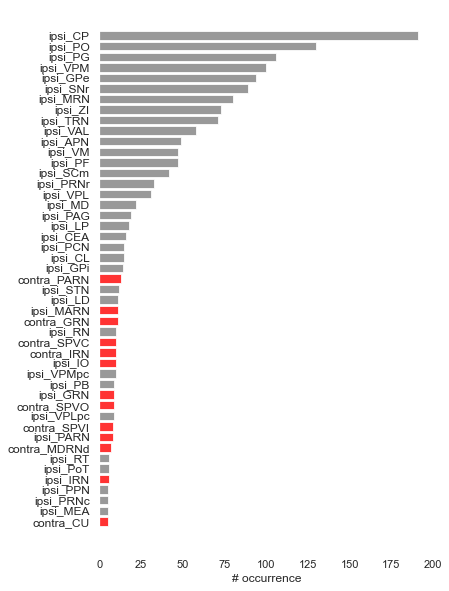

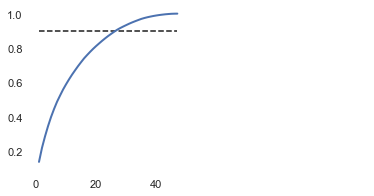

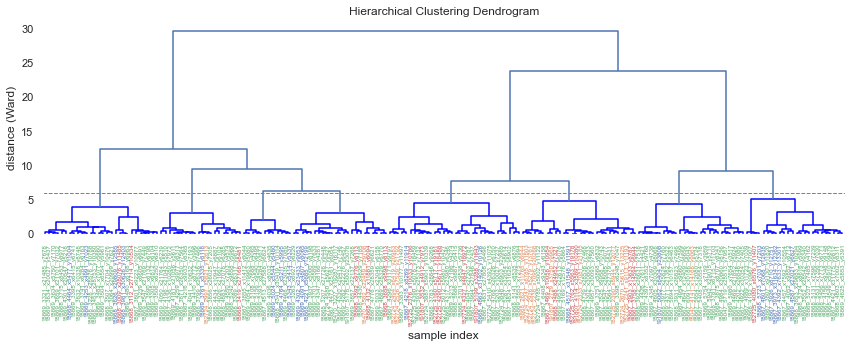

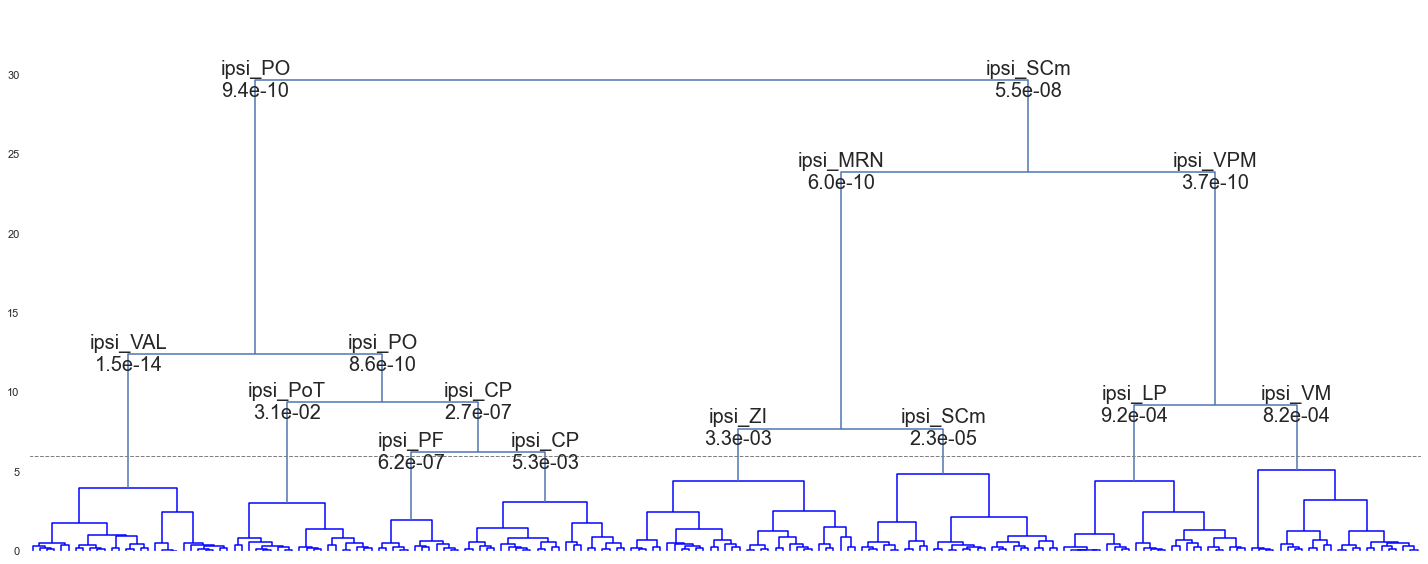

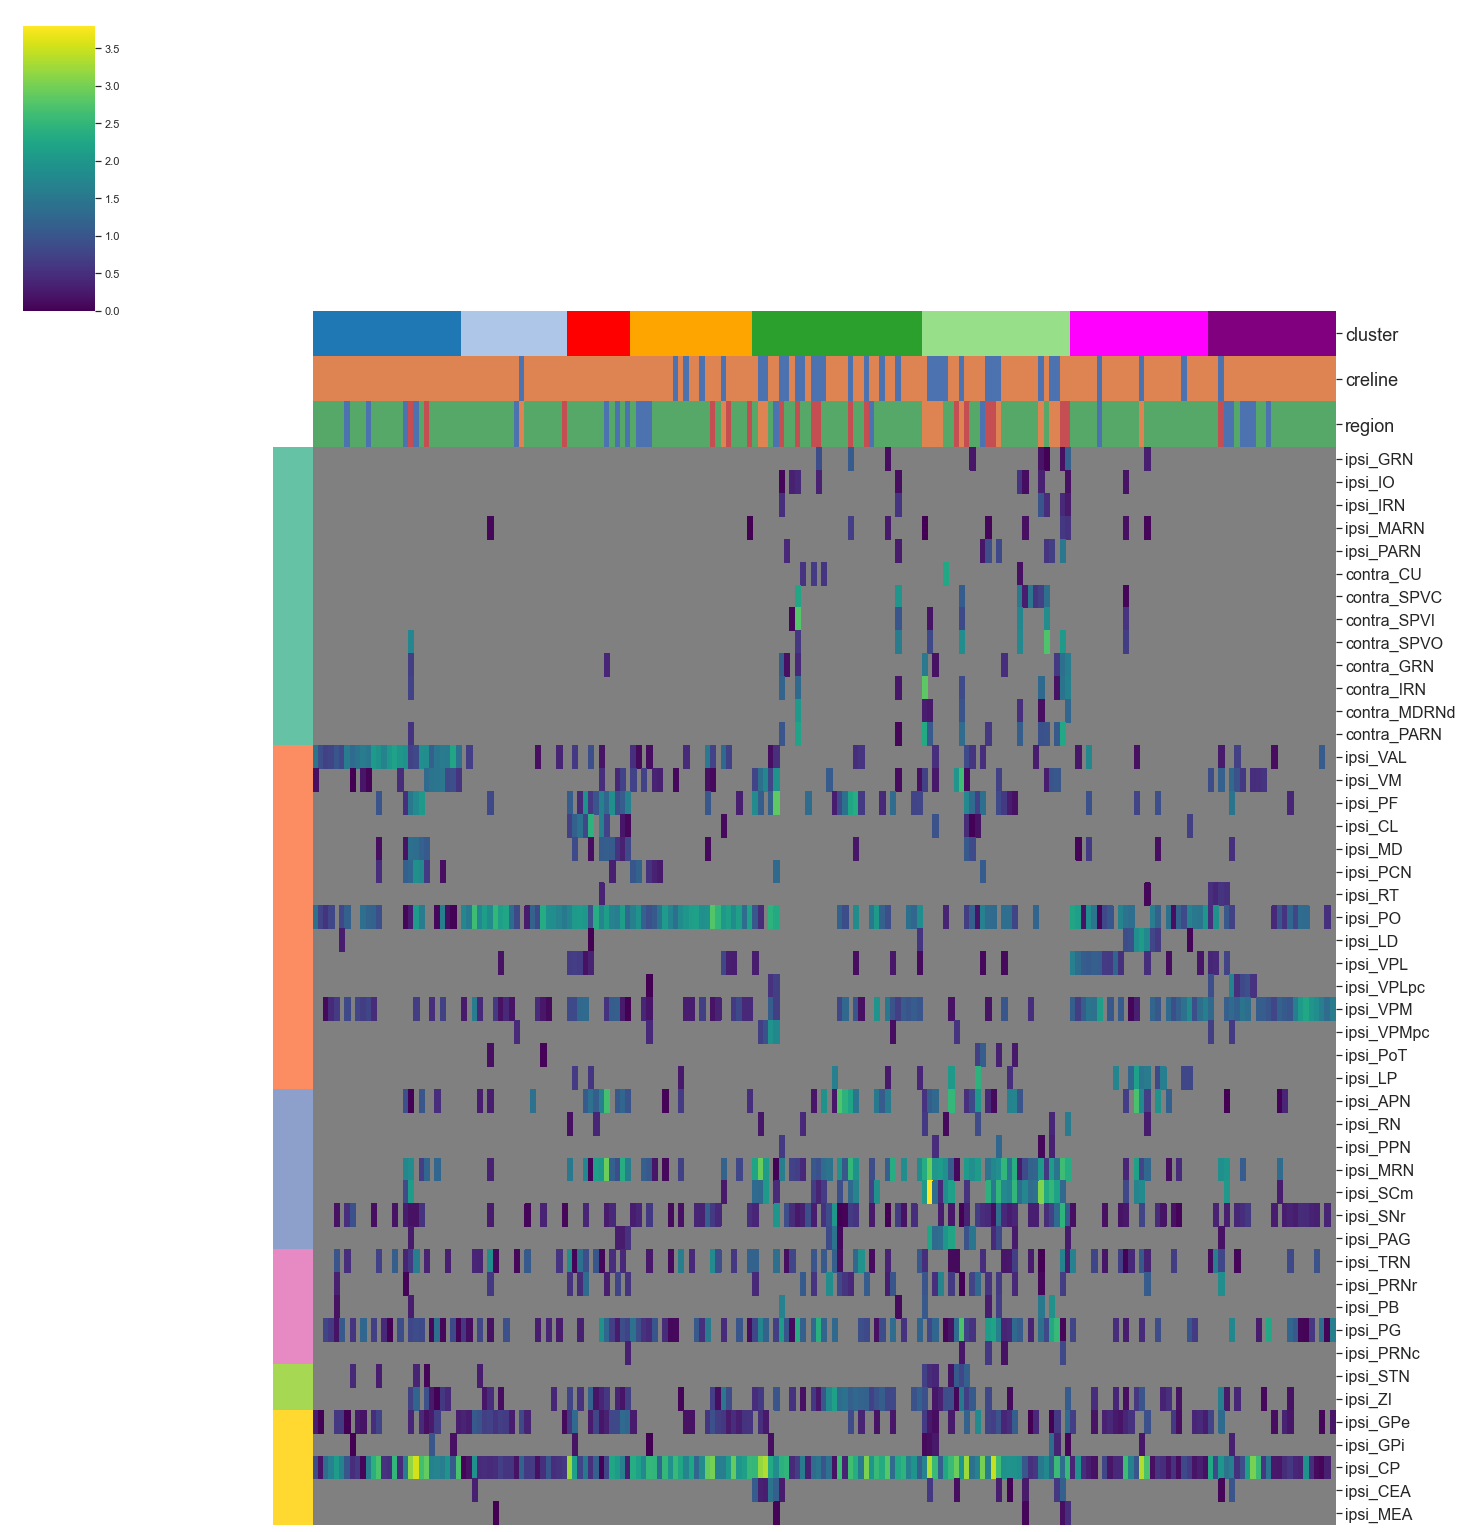

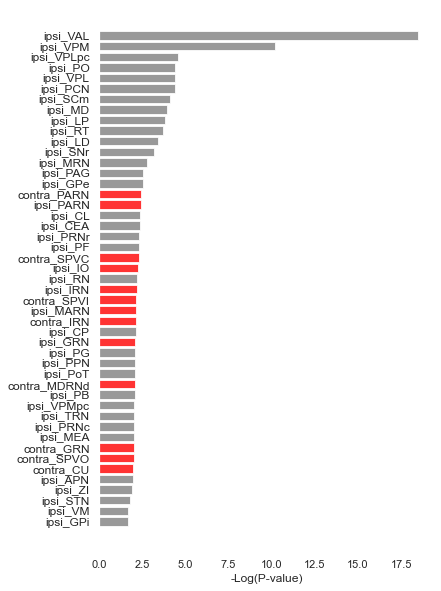

In [318]:
min_cell_count = 5 # regions need to be targeted by at least 'thres_ct' times to be included
min_region_count = 1
combine_ssp = True
combine_my = False
drop_ctx = True

thres = 1 # regions with >1mm projections are defined as 'targeted'
pca_variance = 0.9
do_umap = True
n_neighbors = 10

if do_umap:
    threshold = 6
else:
    threshold = 15

length_dict = {0:36, 0.5:30, 1:22}
    
############################################################################
# 1. Get matrix
############################################################################
clist = metadata.index.tolist()
tdf_all = get_combined_pdf(clist, 
                           thres=thres, 
                           min_cell_count=min_cell_count,
                           min_region_count=min_region_count,
                           combine_ssp=combine_ssp,
                           combine_my=combine_my,
                           drop_ctx=drop_ctx
                   )

tdf_all = drop_local(tdf_all)
tdf_all[tdf_all<thres] = thres
tdf_all = np.log(tdf_all+1-thres)
clist = tdf_all.index.tolist()
feature_list_all = tdf_all.columns.tolist()

print(sorted(tdf_all.columns.tolist()))
print(metadata.loc[clist, 'CellType_full'].value_counts())

show_region_occurrence(tdf_all, thres=0)

############################################################################
# 2. Clustering
############################################################################
zdf = my_dim_reduction(tdf_all, explained_ratio=pca_variance, do_umap=do_umap, n_neighbors=n_neighbors)
ordered_clist, Z_sample = plot_hierarchy(zdf, metadata.loc[zdf.index], thres=threshold)
diff_features_in_dendrogram(zdf, threshold, tdf_all, 
                            save_name='../Figure/L5_ET_dendrogram.pdf', 
                            use_cells=zdf.index.tolist())

############################################################################
# 3. Heatmap
############################################################################

clusters = fcluster(Z_sample, t=threshold, criterion='distance')
clusters = pd.DataFrame({"cluster":clusters}, index=tdf_all.index)
zdf['region'] = metadata.loc[zdf.index, 'CellType']
zdf['creline'] = metadata.loc[zdf.index, 'CreLine']
zdf['cluster'] = clusters.loc[zdf.index, 'cluster']
zdf = zdf.loc[ordered_clist]
ucluster = sorted(clusters['cluster'].unique().tolist())
cluster_map = dict(zip(ucluster, cluster_palette[:len(ucluster)]))

col_colors = pd.DataFrame({'cluster':zdf.loc[ordered_clist, 'cluster'].map(cluster_map),
                           'creline':zdf.loc[ordered_clist, 'creline'].map(cre_cmap),
                           'region':zdf.loc[ordered_clist, 'region'].map(region_cmap)
                          })
feature_list = tdf_all.columns.tolist()
feature_group = assign_feature_to_cluster(tdf_all.loc[zdf.index, feature_list], zdf)
feature_list = feature_group.index.tolist()
row_colors = pd.DataFrame({'region':[group_cmap[i] for i in feature_group['group'].tolist()]}, 
                          index=feature_group.index)
plot_df = tdf_all.loc[ordered_clist, feature_list].copy()

sns.set(rc={'axes.facecolor':'grey'})
g = sns.clustermap(plot_df.transpose(), 
                   mask=(plot_df.transpose()<=0),
                   cmap='viridis', 
                   xticklabels=False,
                   col_colors=col_colors,
                   row_colors=row_colors,
#                    z_score=0,
                   vmin=0,
#                    vmax=4,
                   col_cluster=False,
                   row_cluster=False,
#                    square=True,
#                    cbar_kws=dict(use_gridspec=False,location="top"),
                   figsize=(20,length_dict[thres]))
g.ax_col_colors.set_yticklabels(g.ax_col_colors.get_ymajorticklabels(), fontsize = 18)
g.ax_row_colors.set_xticklabels(g.ax_col_colors.get_xmajorticklabels(), fontsize = 0)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 16)
sns.set(rc={'axes.facecolor':'none'})
g.savefig('../Figure/L5_ET_projection_heatmap.pdf', bbox_inches='tight')

# Select variable features
pv = my_anova(tdf_all.loc[ordered_clist, feature_list].copy(), zdf, plot=True).sort_values(['P-value'])
pv_select = pv[pv['Log10_Pv']>(-np.log10(0.01))].copy()
feature_list_select = pv_select.index.tolist()
print('%d/%d features selected' % (len(feature_list_select), tdf_all.shape[1]))

In [307]:
metadata['Cluster'] = zdf.loc[metadata.index, 'cluster']
metadata.loc[ordered_clist].to_excel('./Projection_classification_PT_v2.xlsx')

## Generate vaa3d snapshots

In [308]:
swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/3_flip_s25_resample/'
swc_list = [swc_path+i for i in os.listdir(swc_path) if i.endswith('swc')]
name_list = [i.split('.')[0] for i in os.listdir(swc_path) if i.endswith('swc')]
df_swc = pd.DataFrame({'swc_file':swc_list}, index=name_list)
ccf_image = '/Users/pengxie/Documents/Research/CCF/template/average_template_25.nrrd.UNIT8.v3draw'

def get_ano(clist, tag):
    f = open('./ano_fig7/'+str(tag)+'.ano', 'w')
    f.write('RAWIMG='+ccf_image+'\n')
    for i in clist:
        f.write('SWCFILE='+df_swc.loc[i, 'swc_file']+'\n')
    f.close()
    return

In [309]:
for ctag in metadata.Cluster.value_counts().index.tolist():
    clist = metadata[metadata['Cluster']==ctag].index.tolist()
    get_ano(clist, ctag)

## MO

# regions:	3
# total cells:	33
# selected cells:	33
# regions:	48
# total cells:	33
# selected cells:	33
# selected regions after combination:	42
# selected cells after combination:	33
['contra_GRN', 'contra_IRN', 'contra_MDRNd', 'contra_PARN', 'contra_PG', 'contra_SPVC', 'contra_SPVI', 'contra_SPVO', 'contra_VM', 'ipsi_APN', 'ipsi_CEA', 'ipsi_CL', 'ipsi_CP', 'ipsi_GPe', 'ipsi_GPi', 'ipsi_GRN', 'ipsi_IO', 'ipsi_IRN', 'ipsi_LHA', 'ipsi_MARN', 'ipsi_MD', 'ipsi_MRN', 'ipsi_NTS', 'ipsi_PAG', 'ipsi_PARN', 'ipsi_PB', 'ipsi_PF', 'ipsi_PG', 'ipsi_PO', 'ipsi_PPN', 'ipsi_PRNc', 'ipsi_PRNr', 'ipsi_RN', 'ipsi_SCm', 'ipsi_SNr', 'ipsi_STN', 'ipsi_TRN', 'ipsi_VAL', 'ipsi_VM', 'ipsi_VPM', 'ipsi_VPMpc', 'ipsi_ZI']
MOp;L5    19
MOs;L5    14
Name: CellType_full, dtype: int64
20/42 features selected


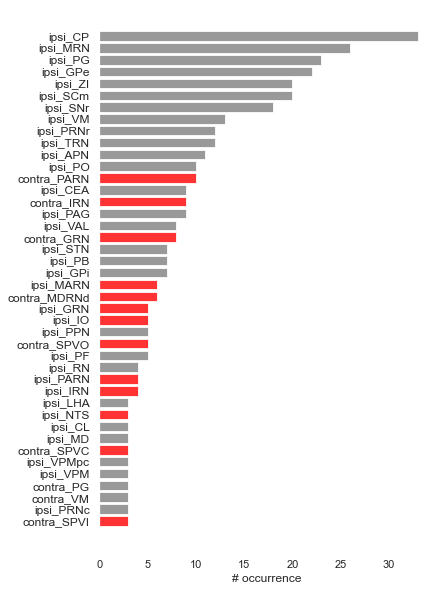

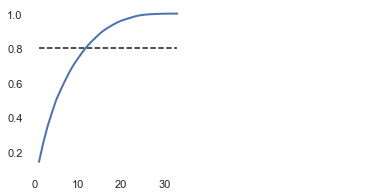

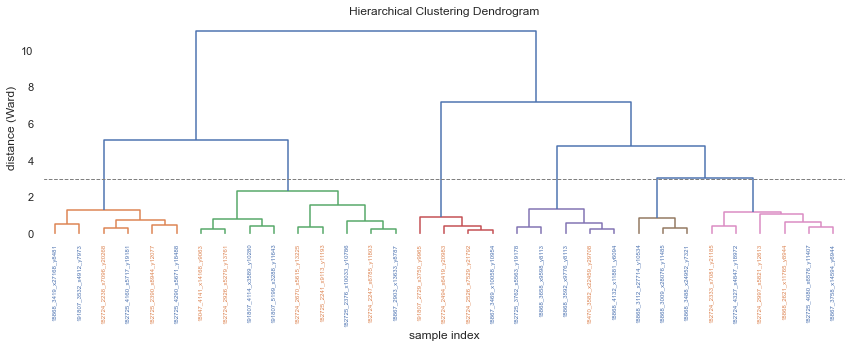

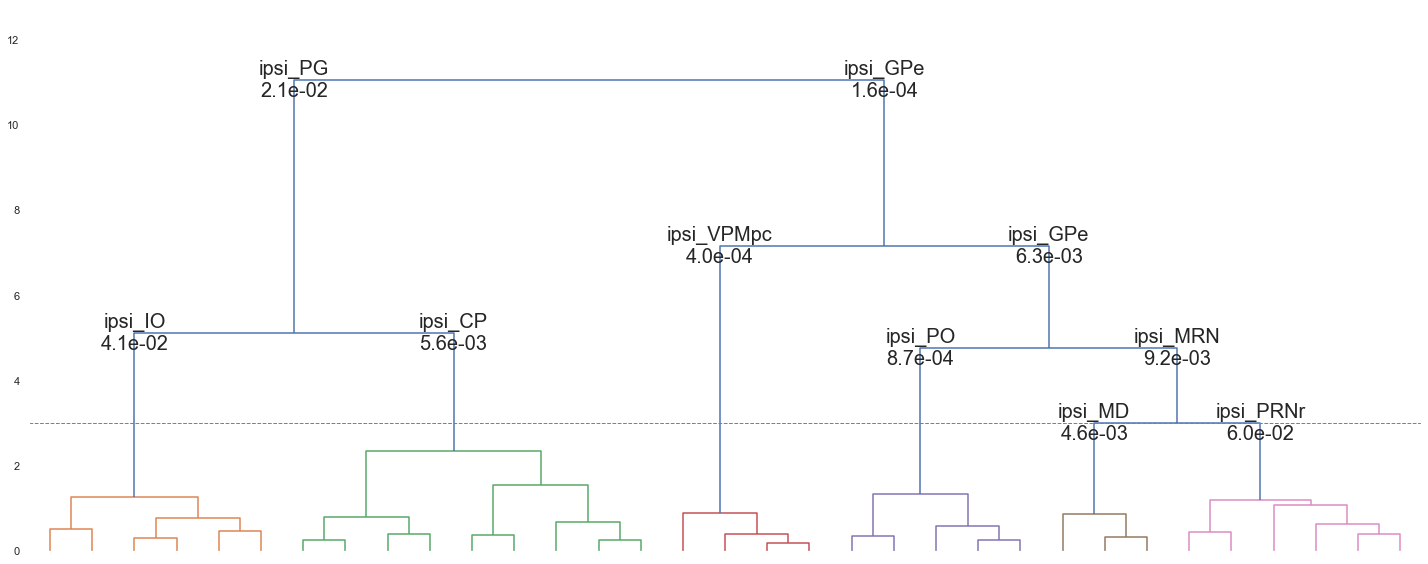

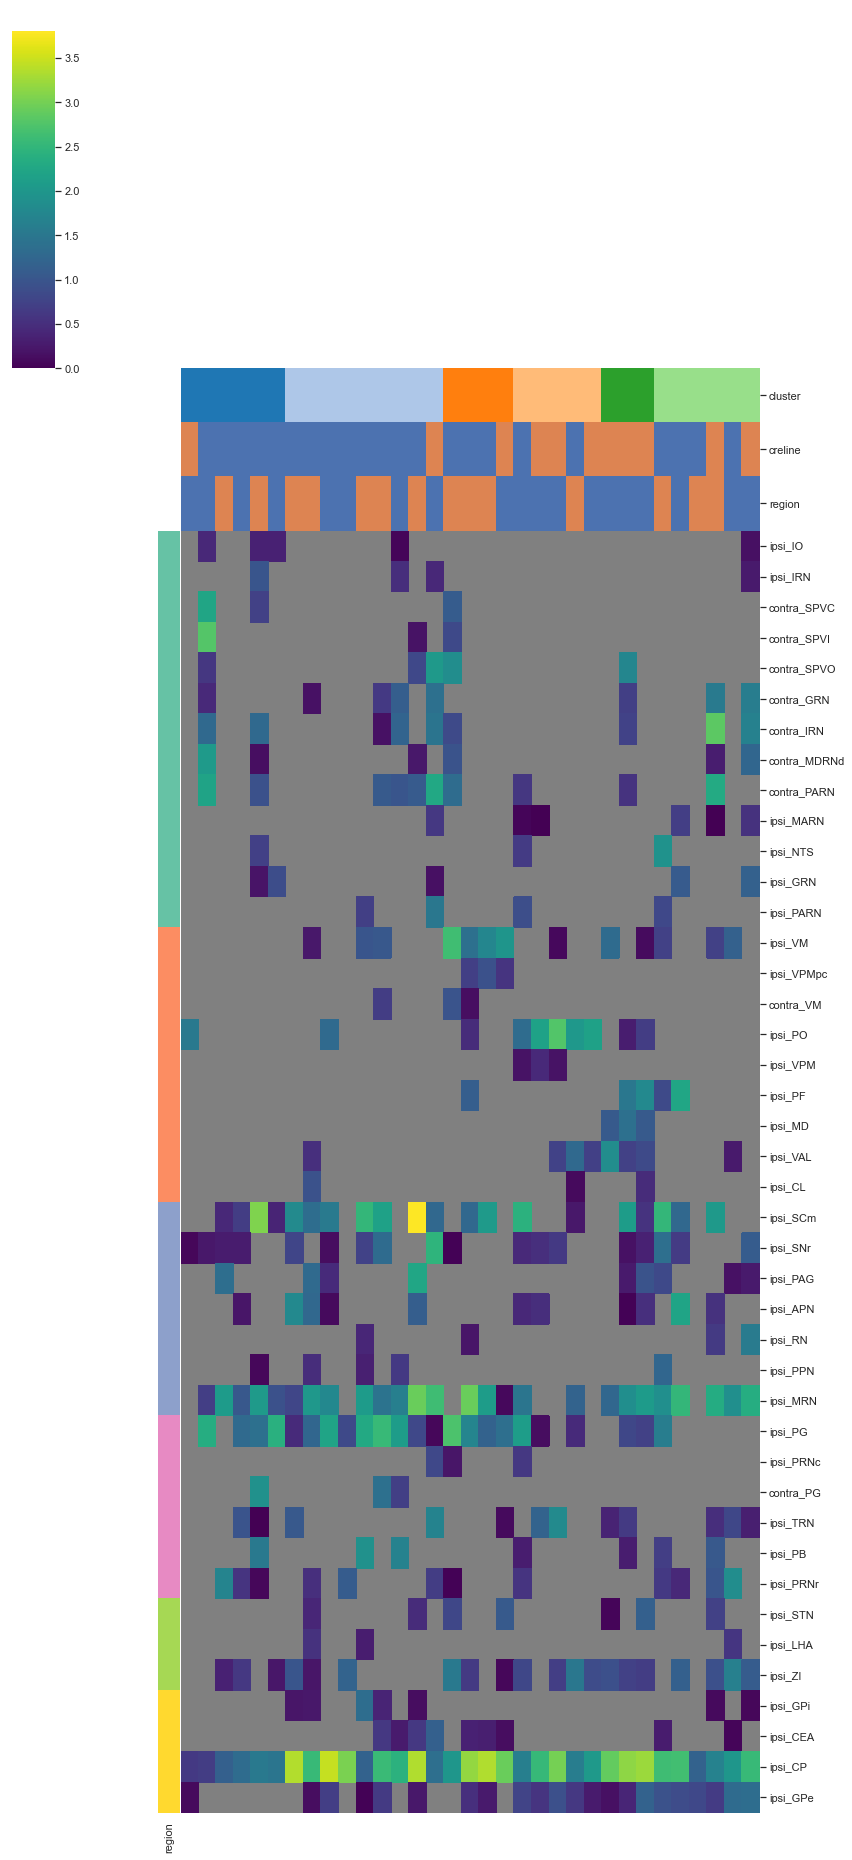

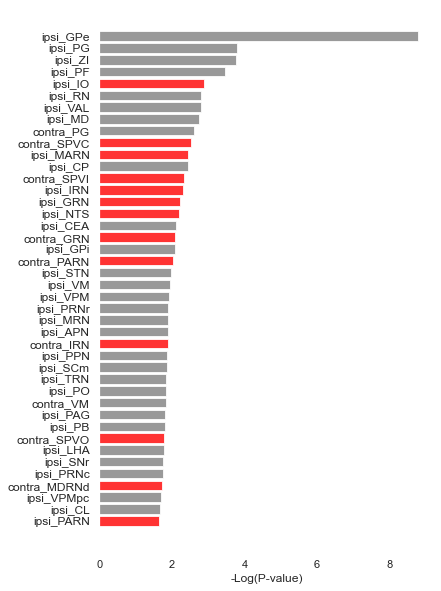

In [262]:
min_cell_count = 3 # regions need to be targeted by at least 'thres_ct' times to be included
min_region_count = 1
combine_ssp = True
combine_my = False
drop_ctx = True

thres = 1 # regions with >1mm projections are defined as 'targeted'
pca_variance = 0.8
do_umap = True
n_neighbors = 5

if do_umap:
    threshold = 3
else:
    threshold = 15

length_dict = {0:36, 0.5:30, 1:26}
    
############################################################################
# 1. Get matrix
############################################################################
clist = metadata[metadata['CellType'].isin(['MOp', 'MOs'])].index.tolist()
tdf_mo = get_combined_pdf(clist, 
                           thres=thres, 
                           min_cell_count=min_cell_count,
                           min_region_count=min_region_count,
                           combine_ssp=combine_ssp,
                           combine_my=combine_my,
                           drop_ctx=drop_ctx
                   )


tdf_mo = drop_local(tdf_mo)
tdf_mo[tdf_mo<thres] = thres
tdf_mo = np.log(tdf_mo+1-thres)
clist = tdf_mo.index.tolist()
feature_list_all = tdf_mo.columns.tolist()

print(sorted(tdf_mo.columns.tolist()))
print(metadata.loc[clist, 'CellType_full'].value_counts())

show_region_occurrence(tdf_mo, thres=0)

############################################################################
# 2. Clustering
############################################################################
zdf = my_dim_reduction(tdf_mo, explained_ratio=pca_variance, do_umap=do_umap, n_neighbors=n_neighbors)
ordered_clist, Z_sample = plot_hierarchy(zdf, metadata.loc[zdf.index], thres=threshold, save=False)
diff_features_in_dendrogram(zdf, threshold, tdf_mo, None, use_cells=zdf.index.tolist())

############################################################################
# 3. Heatmap
############################################################################

clusters = fcluster(Z_sample, t=threshold, criterion='distance')
clusters = pd.DataFrame({"cluster":clusters}, index=tdf_mo.index)
zdf['region'] = metadata.loc[zdf.index, 'CellType']
zdf['creline'] = metadata.loc[zdf.index, 'CreLine']
zdf['cluster'] = clusters.loc[zdf.index, 'cluster']
zdf = zdf.loc[ordered_clist]
ucluster = sorted(clusters['cluster'].unique().tolist())
cluster_map = dict(zip(ucluster, cluster_palette[:len(ucluster)]))

col_colors = pd.DataFrame({'cluster':zdf.loc[ordered_clist, 'cluster'].map(cluster_map),
                           'creline':zdf.loc[ordered_clist, 'creline'].map(cre_cmap),
                           'region':zdf.loc[ordered_clist, 'region'].map(region_cmap)
                          })
feature_list = tdf_mo.columns.tolist()
feature_group = assign_feature_to_cluster(tdf_mo.loc[zdf.index, feature_list], zdf)
feature_list = feature_group.index.tolist()
row_colors = pd.DataFrame({'region':[group_cmap[i] for i in feature_group['group'].tolist()]}, 
                          index=feature_group.index)
plot_df = tdf_mo.loc[ordered_clist, feature_list].copy()

sns.set(rc={'axes.facecolor':'grey'})
g = sns.clustermap(plot_df.transpose(), 
                   mask=(plot_df.transpose()<=0),
                   cmap='viridis', 
                   xticklabels=False,
                   col_colors=col_colors,
                   row_colors=row_colors,
#                    z_score=0,
                   vmin=0,
#                    vmax=4,
                   col_cluster=False,
                   row_cluster=False,
#                    square=True,
#                    cbar_kws=dict(use_gridspec=False,location="top"),
                   figsize=(12,length_dict[thres]))
sns.set(rc={'axes.facecolor':'none'})

# Select variable features
pv = my_anova(tdf_mo.loc[ordered_clist, feature_list].copy(), zdf, plot=True).sort_values(['P-value'])
pv_select = pv[pv['Log10_Pv']>(-np.log10(0.01))].copy()
feature_list_select = pv_select.index.tolist()
print('%d/%d features selected' % (len(feature_list_select), tdf_mo.shape[1]))

# regions:	4
# total cells:	139
# selected cells:	139
# regions:	34
# total cells:	139
# selected cells:	139
# selected regions after combination:	29
# selected cells after combination:	139
['contra_SPVC', 'contra_SPVI', 'ipsi_APN', 'ipsi_CEA', 'ipsi_CL', 'ipsi_CP', 'ipsi_GPe', 'ipsi_GPi', 'ipsi_IO', 'ipsi_LD', 'ipsi_LP', 'ipsi_MARN', 'ipsi_MD', 'ipsi_MRN', 'ipsi_PAG', 'ipsi_PCN', 'ipsi_PF', 'ipsi_PG', 'ipsi_PO', 'ipsi_PRNr', 'ipsi_RN', 'ipsi_SCm', 'ipsi_SNr', 'ipsi_TRN', 'ipsi_VAL', 'ipsi_VM', 'ipsi_VPL', 'ipsi_VPM', 'ipsi_ZI']
SSp;L5    139
Name: CellType_full, dtype: int64
21/29 features selected


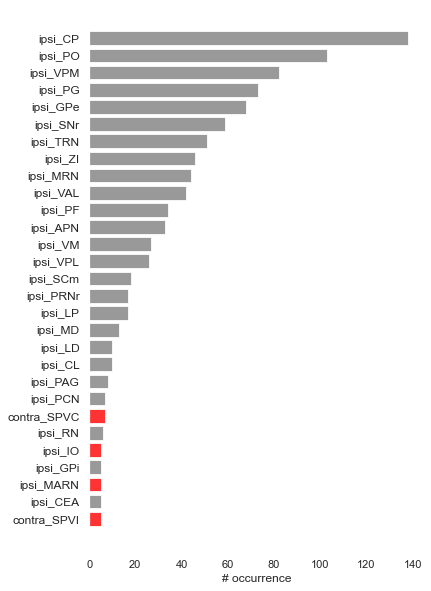

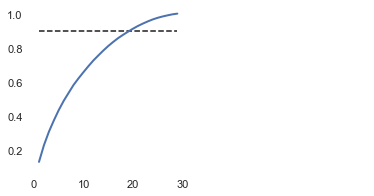

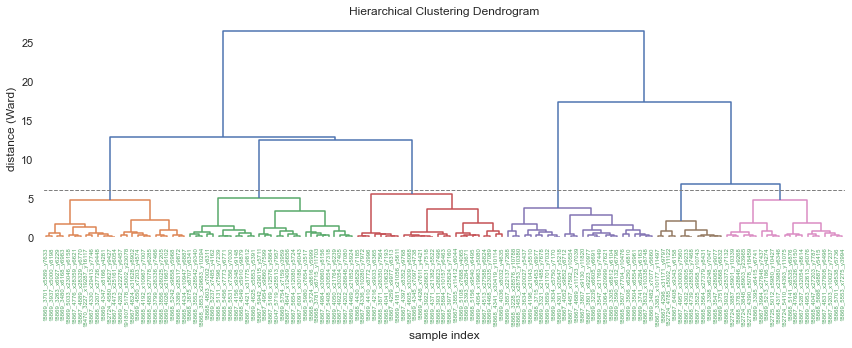

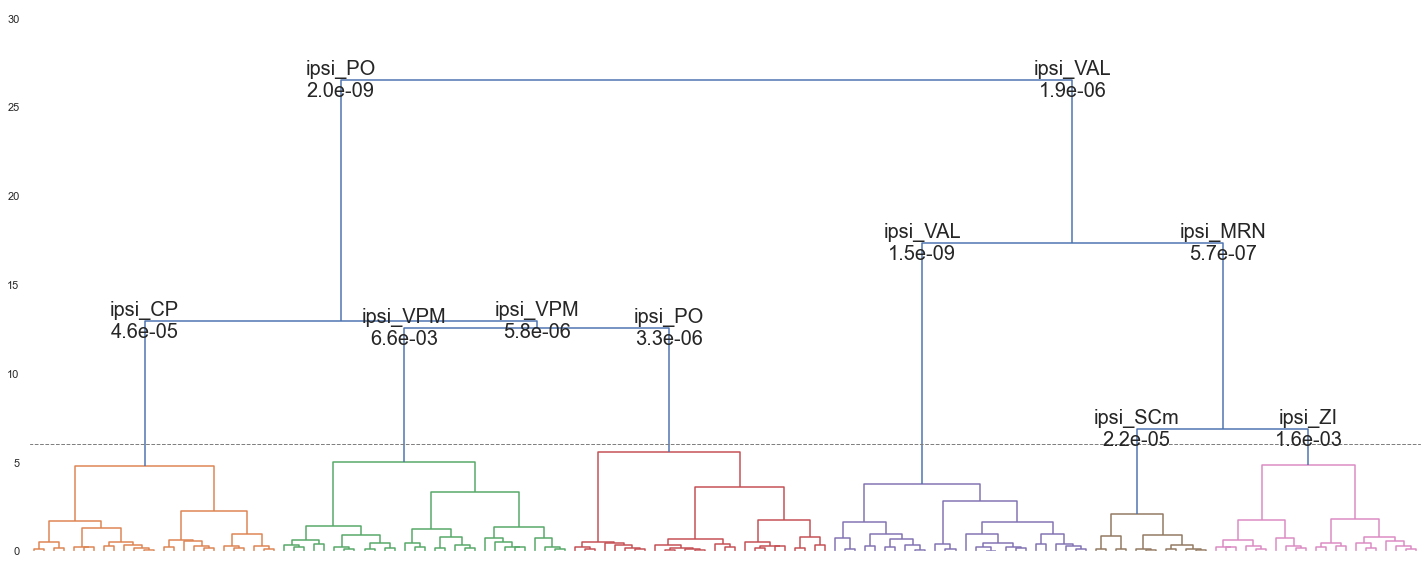

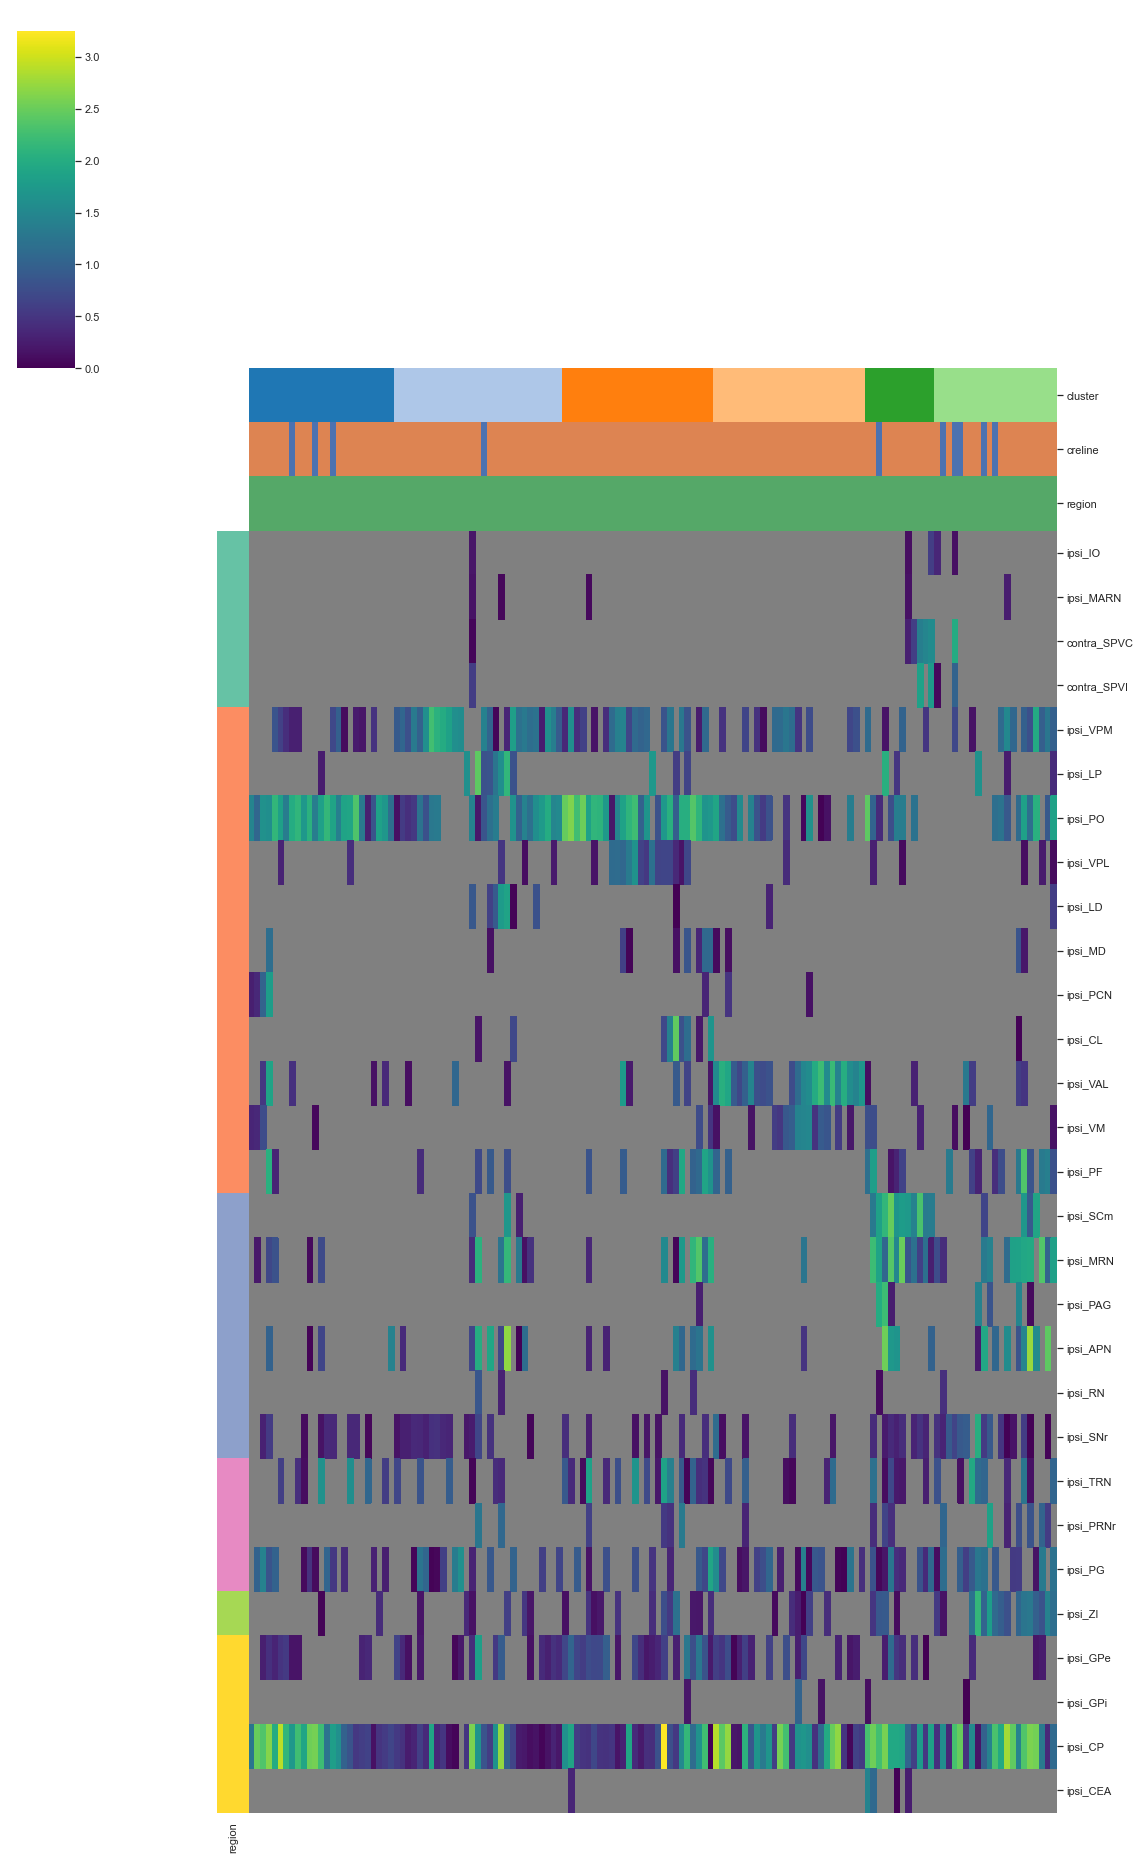

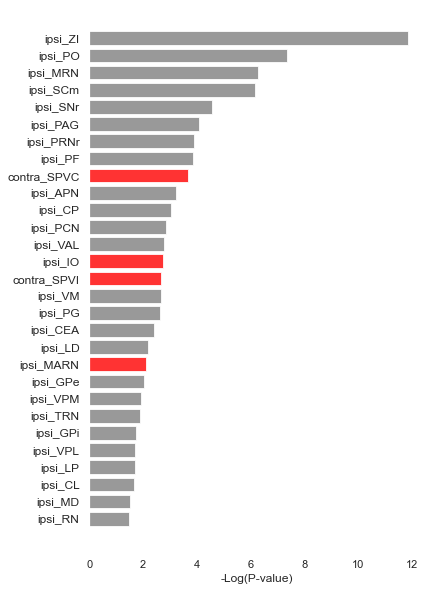

In [275]:
min_cell_count = 5 # regions need to be targeted by at least 'thres_ct' times to be included
min_region_count = 1
combine_ssp = True
combine_my = False
drop_ctx = True

thres = 1 # regions with >1mm projections are defined as 'targeted'
pca_variance = 0.9
do_umap = True
n_neighbors = 8

if do_umap:
    threshold = 6
else:
    threshold = 15

length_dict = {0:36, 0.5:30, 1:26}
    
############################################################################
# 1. Get matrix
############################################################################
clist = metadata[metadata['CellType'].isin(['SSp'])].index.tolist()
tdf_mo = get_combined_pdf(clist, 
                           thres=thres, 
                           min_cell_count=min_cell_count,
                           min_region_count=min_region_count,
                           combine_ssp=combine_ssp,
                           combine_my=combine_my,
                           drop_ctx=drop_ctx
                   )


tdf_mo = drop_local(tdf_mo)
tdf_mo[tdf_mo<thres] = thres
tdf_mo = np.log(tdf_mo+1-thres)
clist = tdf_mo.index.tolist()
feature_list_all = tdf_mo.columns.tolist()

print(sorted(tdf_mo.columns.tolist()))
print(metadata.loc[clist, 'CellType_full'].value_counts())

show_region_occurrence(tdf_mo, thres=0)

############################################################################
# 2. Clustering
############################################################################
zdf = my_dim_reduction(tdf_mo, explained_ratio=pca_variance, do_umap=do_umap, n_neighbors=n_neighbors)
ordered_clist, Z_sample = plot_hierarchy(zdf, metadata.loc[zdf.index], thres=threshold, save=False)
diff_features_in_dendrogram(zdf, threshold, tdf_mo, None, use_cells=zdf.index.tolist())

############################################################################
# 3. Heatmap
############################################################################

clusters = fcluster(Z_sample, t=threshold, criterion='distance')
clusters = pd.DataFrame({"cluster":clusters}, index=tdf_mo.index)
zdf['region'] = metadata.loc[zdf.index, 'CellType']
zdf['creline'] = metadata.loc[zdf.index, 'CreLine']
zdf['cluster'] = clusters.loc[zdf.index, 'cluster']
zdf = zdf.loc[ordered_clist]
ucluster = sorted(clusters['cluster'].unique().tolist())
cluster_map = dict(zip(ucluster, cluster_palette[:len(ucluster)]))

col_colors = pd.DataFrame({'cluster':zdf.loc[ordered_clist, 'cluster'].map(cluster_map),
                           'creline':zdf.loc[ordered_clist, 'creline'].map(cre_cmap),
                           'region':zdf.loc[ordered_clist, 'region'].map(region_cmap)
                          })
feature_list = tdf_mo.columns.tolist()
feature_group = assign_feature_to_cluster(tdf_mo.loc[zdf.index, feature_list], zdf)
feature_list = feature_group.index.tolist()
row_colors = pd.DataFrame({'region':[group_cmap[i] for i in feature_group['group'].tolist()]}, 
                          index=feature_group.index)
plot_df = tdf_mo.loc[ordered_clist, feature_list].copy()

sns.set(rc={'axes.facecolor':'grey'})
g = sns.clustermap(plot_df.transpose(), 
                   mask=(plot_df.transpose()<=0),
                   cmap='viridis', 
                   xticklabels=False,
                   col_colors=col_colors,
                   row_colors=row_colors,
#                    z_score=0,
                   vmin=0,
#                    vmax=4,
                   col_cluster=False,
                   row_cluster=False,
#                    square=True,
#                    cbar_kws=dict(use_gridspec=False,location="top"),
                   figsize=(16,length_dict[thres]))
sns.set(rc={'axes.facecolor':'none'})

# Select variable features
pv = my_anova(tdf_mo.loc[ordered_clist, feature_list].copy(), zdf, plot=True).sort_values(['P-value'])
pv_select = pv[pv['Log10_Pv']>(-np.log10(0.01))].copy()
feature_list_select = pv_select.index.tolist()
print('%d/%d features selected' % (len(feature_list_select), tdf_mo.shape[1]))

Round 1: 9 outliers; threshold=5.00e+00
Round 2: 1 outliers; threshold=5.00e+00
Round 3: 0 outliers; threshold=5.00e+00
Total outliers: 10
# clusters:	9


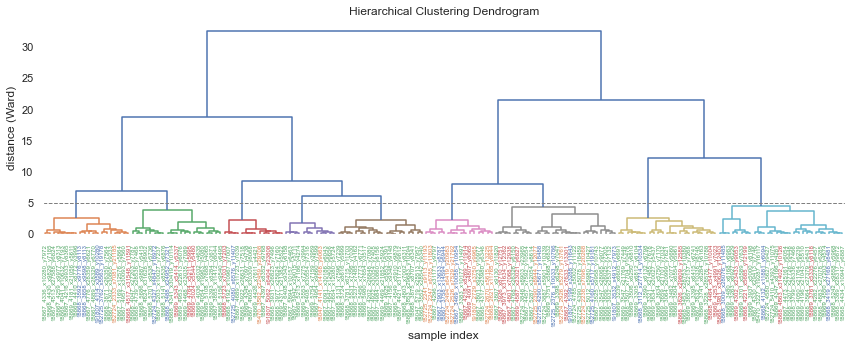

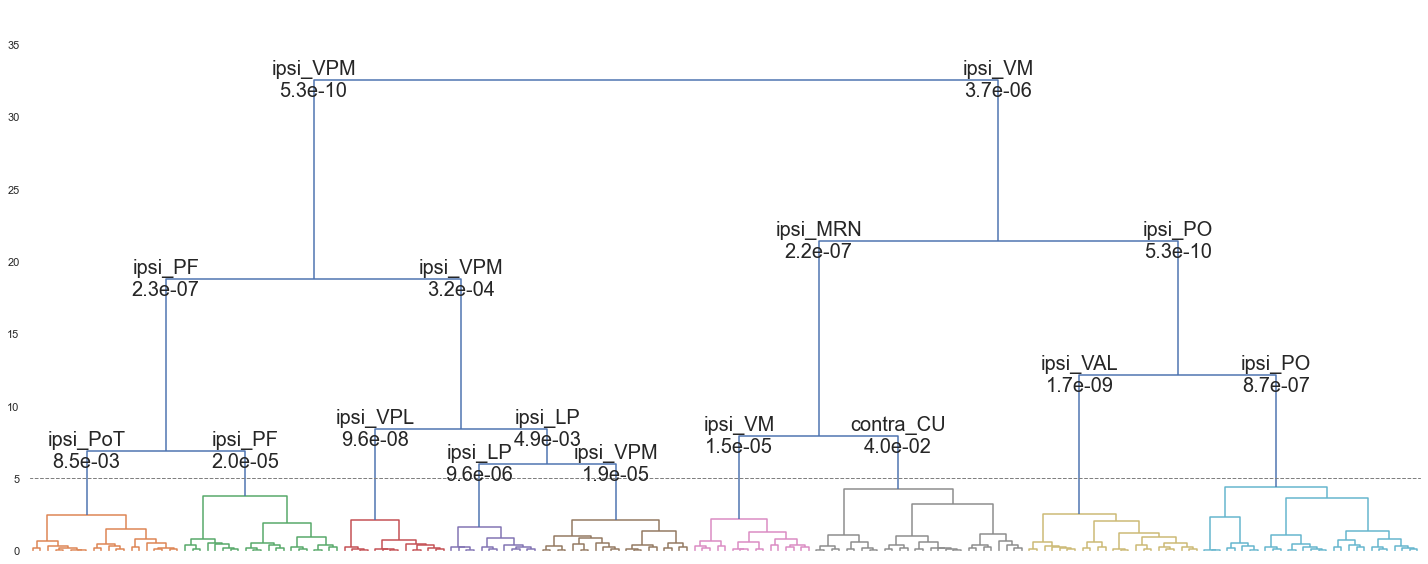

In [223]:
def get_outlier(co_cluster, threshold, min_cluster_size=3, pv_thres=0.1):

    # 1. Call clusters
    cell_names = co_cluster.index.tolist()
    Z_sample = linkage(co_cluster, 'ward')
    clusters = fcluster(Z_sample, t=threshold, criterion='distance')

    clusters = pd.DataFrame({"cluster":clusters}, index=cell_names)
    clusters = pd.concat([clusters, metadata.loc[cell_names, ['CellType', 'Brain_id',]]], axis=1)
    u_clusters = sorted(list(set(clusters.cluster.tolist())))

    # 2. find outliers
    feature_dict = {"Projection":sklearn.metrics.pairwise.euclidean_distances(get_zdf_feature_part(zdf.loc[cell_names])),
                   }
    outlier_df = pd.DataFrame(index=cell_names)
    outlier_df_distance = pd.DataFrame(index=cell_names)

    for k, feature in enumerate(list(feature_dict.keys())):
        dist_df = pd.DataFrame(feature_dict[feature], index=cell_names, columns=cell_names)
        background_dist = []
        for cur_cluster in u_clusters:
            cells_in_cluster = clusters.index[clusters.cluster==cur_cluster]
            dist_in_cluster = np.array(dist_df.loc[cells_in_cluster, cells_in_cluster])
            iu1 = np.triu_indices(len(dist_in_cluster), 1)
            background_dist = background_dist + dist_in_cluster[iu1].tolist()
        pv_list = []
        dist_list = []

        for cell in cell_names:
            cur_cluster = clusters.loc[cell, "cluster"]
            cells_in_cluster = clusters.index[(clusters.cluster==cur_cluster) & (clusters.index!=cell)]
            cells_out_cluster = clusters.index[clusters.cluster!=cur_cluster]            
            if len(cells_in_cluster)<(min_cluster_size-1):
                # Set cell as outlier if cluster is too small
                pv_list.append(0.01)
                dist_list.append(1e6)
            else:
#                 dist_in_cluster = dist_df.loc[cell, cells_in_cluster].sort_values()
                dist_in_cluster = dist_df.loc[cell, cells_in_cluster].sort_values()[:min(2, len(cells_in_cluster))]
                dist_out_cluster = np.array(dist_df.loc[cells_out_cluster, cells_out_cluster]).reshape(-1,)
                _, pv = scipy.stats.mannwhitneyu(dist_in_cluster, 
                                                 background_dist,
#                                                  dist_out_cluster,
                                                 alternative='greater')
                pv_list.append(pv)
                dist_list.append(np.median(dist_in_cluster))
        outlier_df[feature] = pv_list
        outlier_df_distance[feature] = dist_list
    outlier_df = pd.concat([outlier_df, clusters], axis=1)
    outlier_df_distance = pd.concat([outlier_df_distance, clusters], axis=1)
    
    outlier_df["Score"] = -np.sum(np.log10(outlier_df[list(feature_dict.keys())]), axis=1)

    outlier_cells = outlier_df.index[outlier_df.Score>1].tolist()
    return outlier_df.loc[outlier_cells].sort_values("cluster"), outlier_df_distance.loc[outlier_cells].sort_values("cluster"), outlier_cells

cur_cell_list = zdf.index.tolist()
cell_names = zdf.index.to_list()
tp_thres = 1
for iteration in range(1, 10):
    outlier_df, outlier_df_distance, cur_outlier_list = get_outlier(get_zdf_feature_part(zdf.loc[cur_cell_list]), 
                                                                    tp_thres)
    print("Round %d: %d outliers; threshold=%.2e" % (iteration, len(cur_outlier_list), threshold))
    if len(cur_outlier_list)==0:
        break
    cur_cell_list = [j for j in cur_cell_list if not j in cur_outlier_list]

selected_cells = cur_cell_list
outlier_cells = [i for i in cell_names if not i in selected_cells]
print("Total outliers: %d" % len(outlier_cells))


zdf_selected = zdf.loc[selected_cells]
ordered_clist, Z_selected = plot_hierarchy(get_zdf_feature_part(zdf_selected), 
                                         metadata=metadata.loc[selected_cells],
                                         thres=threshold, save=False
                                        )
clusters = fcluster(Z_selected, t=threshold, criterion='distance')
clusters = pd.DataFrame({"cluster":clusters}, index=selected_cells)
u_clusters = sorted(list(set(clusters.cluster.tolist())))
print('# clusters:\t%d' % (len(u_clusters)))
zdf_selected['region'] = metadata.loc[zdf_selected.index, 'CellType']
zdf_selected['creline'] = metadata.loc[zdf_selected.index, 'CreLine']
zdf_selected['cluster'] = clusters.loc[zdf_selected.index, 'cluster']

cell_names = zdf_selected.index.tolist()
diff_features_in_dendrogram(zdf_selected, threshold, 
                            tdf_all.loc[selected_cells], 
                            None, 
                            use_cells=selected_cells)



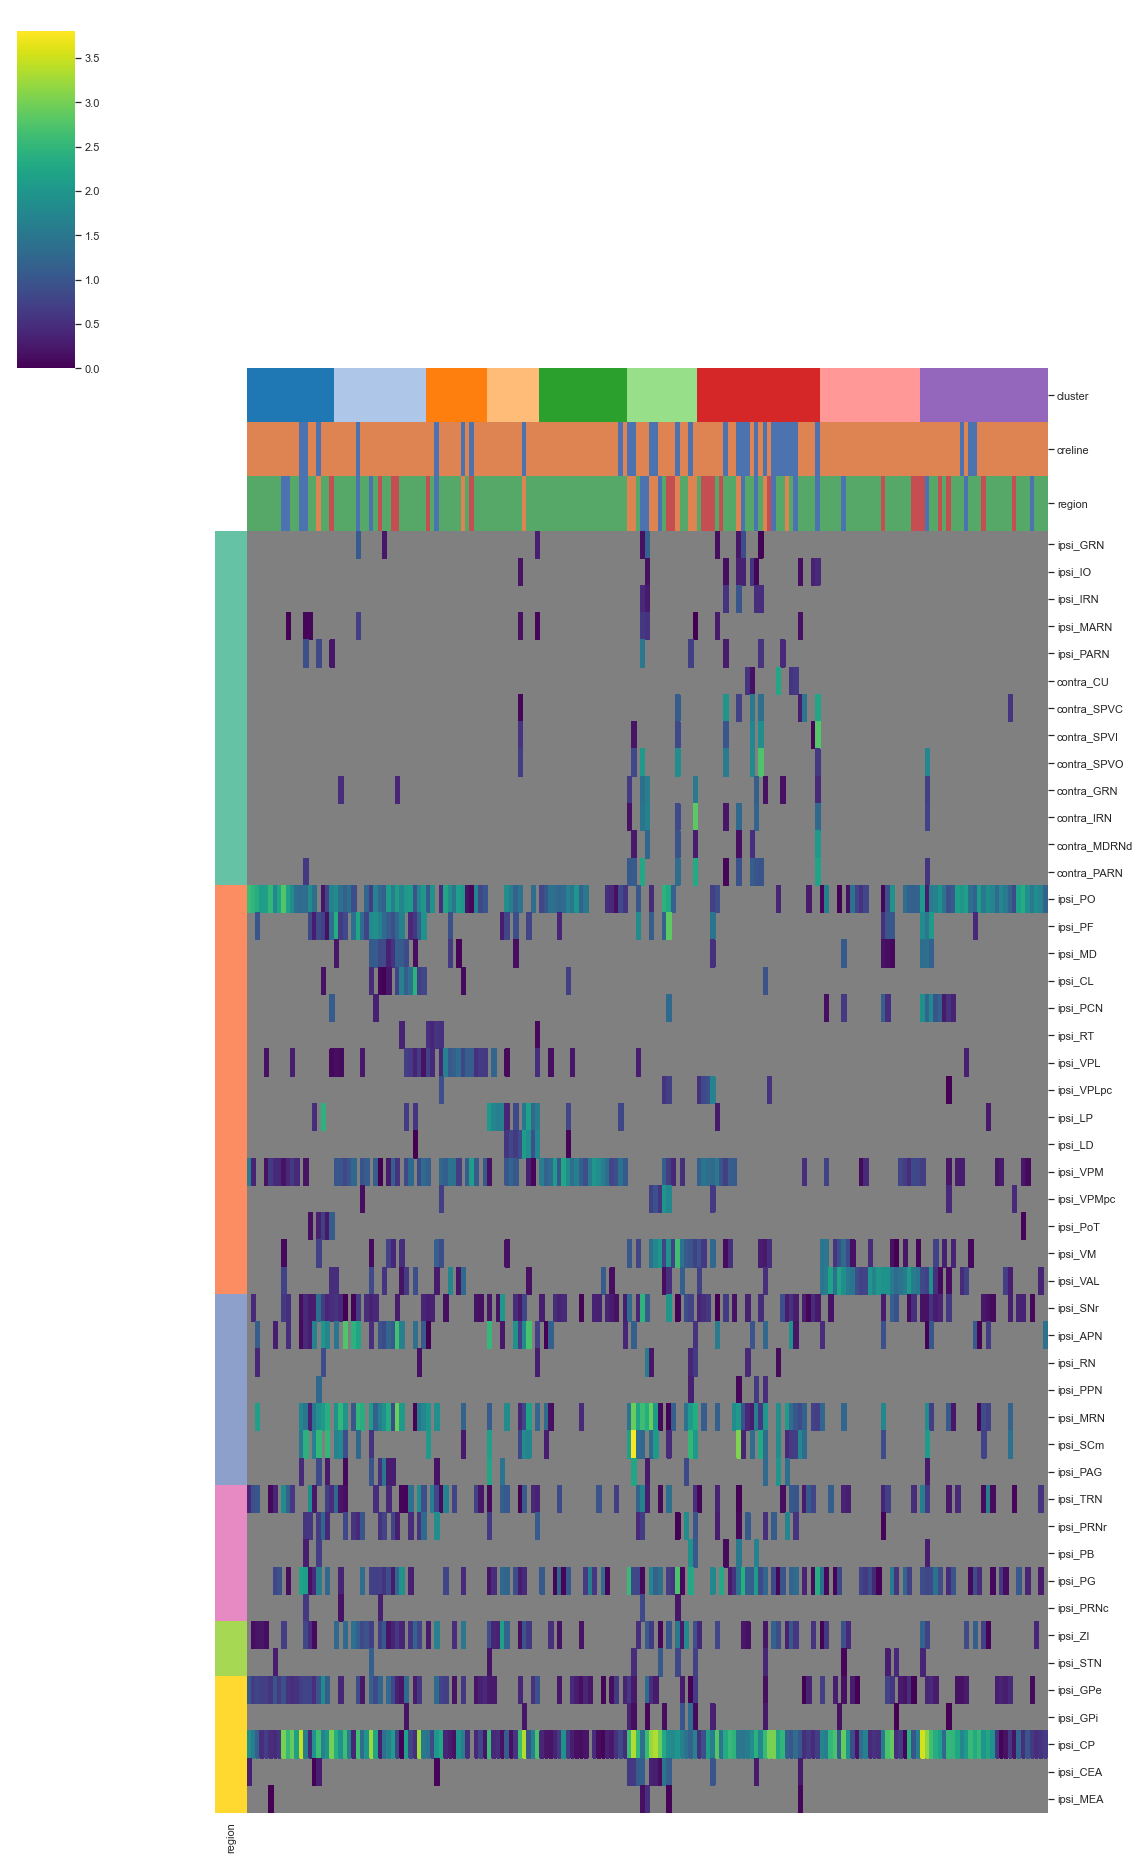

In [224]:
############################################################################
# 3. Heatmap
############################################################################

u_clusters = sorted(zdf_selected['cluster'].unique().tolist())
cluster_map = dict(zip(u_clusters, cluster_palette[:len(u_clusters)]))

col_colors = pd.DataFrame({'cluster':zdf_selected.loc[ordered_clist, 'cluster'].map(cluster_map),
                           'creline':zdf_selected.loc[ordered_clist, 'creline'].map(cre_cmap),
                           'region':zdf_selected.loc[ordered_clist, 'region'].map(region_cmap)
                          })
feature_list = tdf_all.columns.tolist()
feature_group = assign_feature_to_cluster(tdf_all.loc[zdf_selected.index, feature_list], zdf_selected)
feature_list = feature_group.index.tolist()
row_colors = pd.DataFrame({'region':[group_cmap[i] for i in feature_group['group'].tolist()]}, 
                          index=feature_group.index)
plot_df = tdf_all.loc[ordered_clist, feature_list].copy()

sns.set(rc={'axes.facecolor':'grey'})
g = sns.clustermap(plot_df.transpose(), 
                   mask=(plot_df.transpose()<=0),
                   cmap='viridis', 
                   xticklabels=False,
                   col_colors=col_colors,
                   row_colors=row_colors,
#                    z_score=0,
                   vmin=0,
#                    vmax=4,
                   col_cluster=False,
                   row_cluster=False,
#                    square=True,
#                    cbar_kws=dict(use_gridspec=False,location="top"),
                   figsize=(16,length_dict[thres]))
sns.set(rc={'axes.facecolor':'none'})

In [225]:
tp = sum_regions(tdf_all, 'MY')

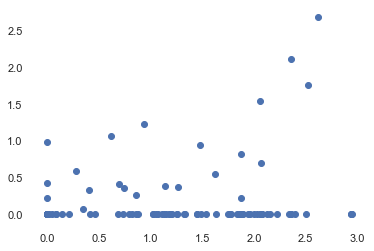

In [226]:
plt.scatter(tp['ipsi_MRN'], tp['ipsi_MY'])

## 2nd iteration

38/47 features selected


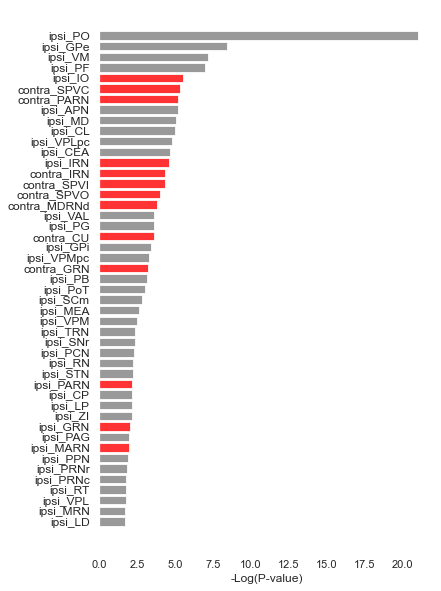

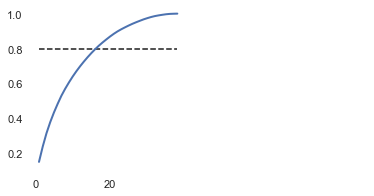

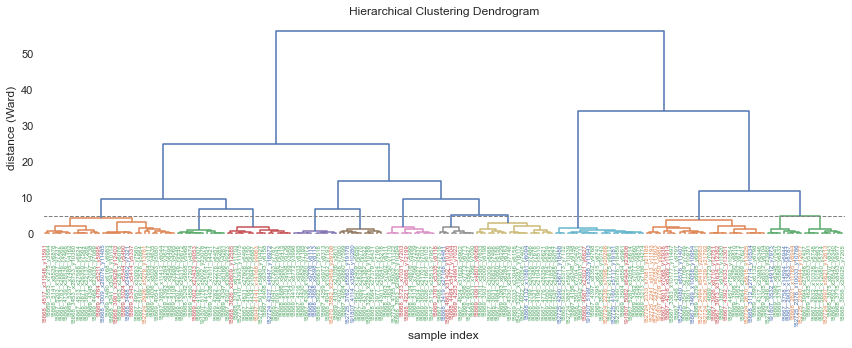

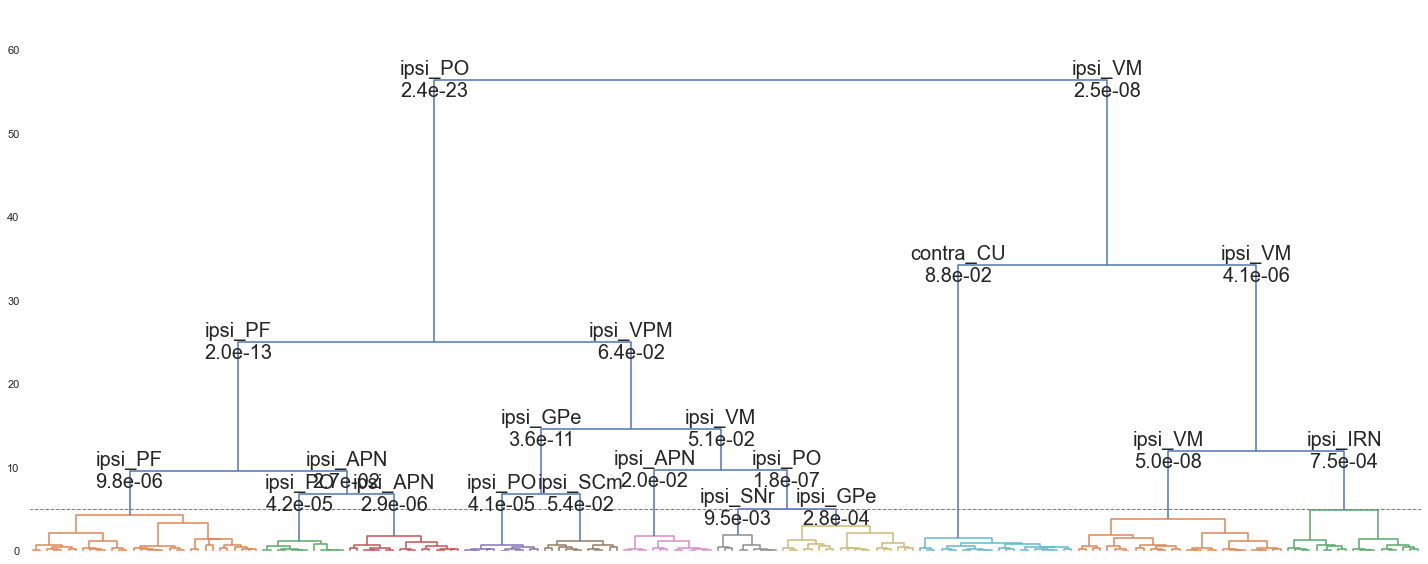

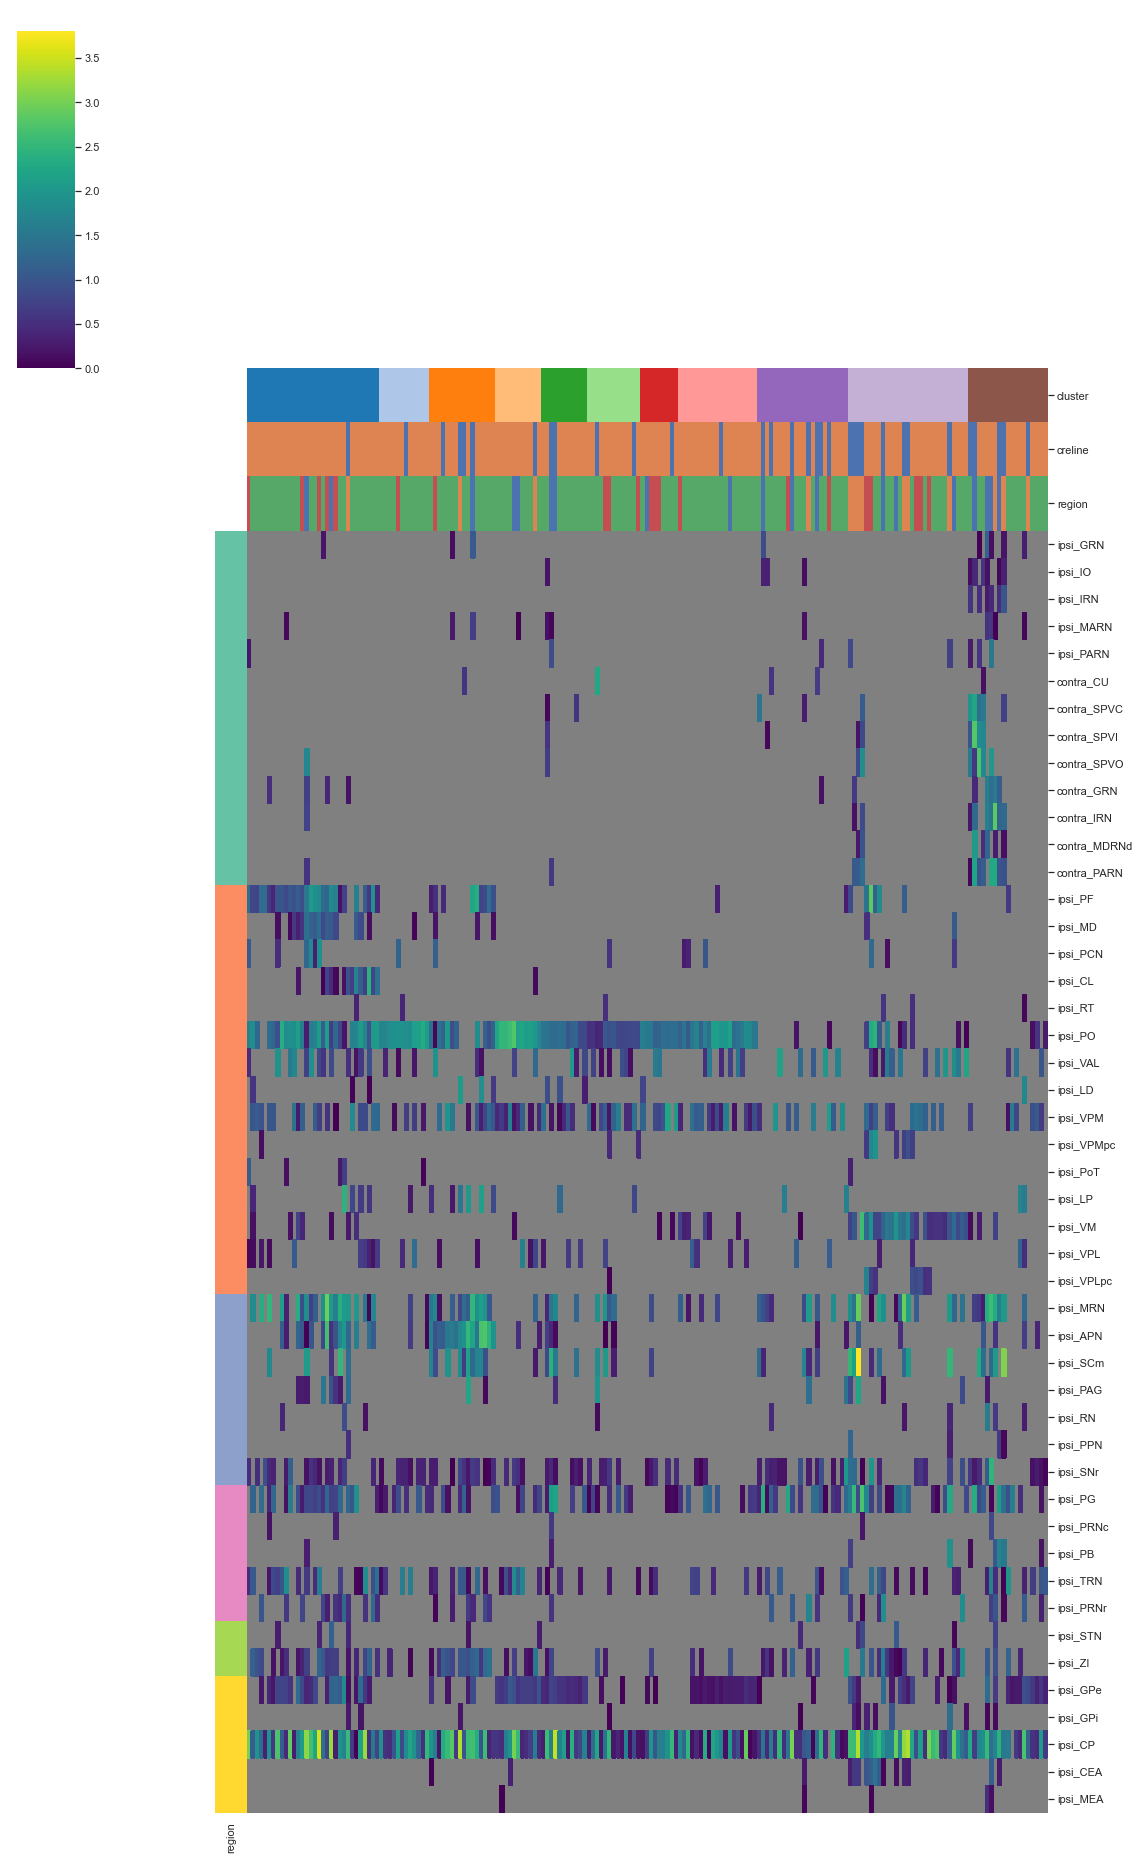

In [220]:
# Select variable features
pv = my_anova(tdf_all.loc[ordered_clist, feature_list].copy(), zdf, plot=True).sort_values(['P-value'])
pv_select = pv[pv['Log10_Pv']>(-np.log10(0.01))].copy()
feature_list_select = pv_select.index.tolist()
print('%d/%d features selected' % (len(feature_list_select), tdf_all.shape[1]))

############################################################################
# 1. Get matrix
############################################################################
tdf = tdf_all[feature_list_select].copy()

############################################################################
# 2. Clustering
############################################################################
zdf_2 = my_dim_reduction(tdf, explained_ratio=pca_variance, do_umap=do_umap, n_neighbors=n_neighbors)
ordered_clist, Z_sample = plot_hierarchy(zdf_2, metadata.loc[zdf_2.index], thres=threshold, save=False)
diff_features_in_dendrogram(zdf_2, threshold, tdf, None, use_cells=zdf_2.index.tolist())

############################################################################
# 3. Heatmap
############################################################################
clusters = fcluster(Z_sample, t=threshold, criterion='distance')
clusters = pd.DataFrame({"cluster":clusters}, index=tdf.index)
zdf_2['region'] = metadata.loc[zdf_2.index, 'CellType']
zdf_2['creline'] = metadata.loc[zdf_2.index, 'CreLine']
zdf_2['cluster'] = clusters.loc[zdf_2.index, 'cluster']
zdf_2 = zdf_2.loc[ordered_clist]
ucluster = sorted(clusters['cluster'].unique().tolist())
cluster_map = dict(zip(ucluster, cluster_palette[:len(ucluster)]))

col_colors = pd.DataFrame({'cluster':zdf_2.loc[ordered_clist, 'cluster'].map(cluster_map),
                           'creline':zdf_2.loc[ordered_clist, 'creline'].map(cre_cmap),
                           'region':zdf_2.loc[ordered_clist, 'region'].map(region_cmap)
                          })
feature_list = tdf_all.columns.tolist()
feature_group = assign_feature_to_cluster(tdf_all.loc[zdf_2.index, feature_list], zdf_2)
feature_list = feature_group.index.tolist()
row_colors = pd.DataFrame({'region':[group_cmap[i] for i in feature_group['group'].tolist()]}, 
                          index=feature_group.index)
plot_df = tdf_all.loc[ordered_clist, feature_list]

sns.set(rc={'axes.facecolor':'grey'})
g = sns.clustermap(plot_df.transpose(), 
                   mask=(plot_df.transpose()<=0),
                   cmap='viridis', 
                   xticklabels=False,
                   col_colors=col_colors,
                   row_colors=row_colors,
#                    z_score=0,
                   vmin=0,
#                    vmax=4,
                   col_cluster=False,
                   row_cluster=False,
#                    square=True,
#                    cbar_kws=dict(use_gridspec=False,location="top"),
                   figsize=(16,length_dict[thres]))
sns.set(rc={'axes.facecolor':'none'})